In [64]:
from selenium import webdriver
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup
import re
import time
from datetime import date, datetime, timedelta
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.linalg import cholesky
from scipy import stats
import random
import pulp
from pulp import *
import statsmodels.api as sm

In [65]:
file = open("consolidated_roto.pkl",'rb')
data = pkl.load(file)

In [66]:
# some important helper functions

def add_position_requirement(prob,example_results, example_projections, choices, pos, number):
    players = list(example_projections.keys())
    POS = list(example_results[example_results.apply(lambda x: pos in x['Pos'].split('/'), axis=1)].Player)
    POS = [re.sub(r'([^\s\w]|_)+', '', a) for a in POS]
    POS = [name.split()[0]+ " " + name.split()[1] for name in POS]
    prob += lpSum([choices[v] for v in POS if v in players]) >= number

def add_all_position_requirements(prob, results, projections, choices):
    add_position_requirement(prob, results, projections,choices, 'C',1)
    add_position_requirement(prob, results, projections,choices,  'PG', 1)
    add_position_requirement(prob, results, projections,choices, 'SG', 1)
    add_position_requirement(prob, results, projections,choices, 'PF', 1)
    add_position_requirement(prob, results, projections,choices, 'SF', 1)
    add_position_requirement(prob, results, projections,choices, 'F', 2)
    add_position_requirement(prob, results, projections,choices, 'G', 2)
    
def get_Fpts(df, player):
    df = df[df['Player'] == player]
    #print(df)
    #print(player)
    #return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    if df.empty:
        return -1
    return 0 if df.empty or np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    #try:
    #    return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    #except:
        #print("??? {}".format(player))
    #    return 0
def get_payout(df, points):
    df = df[df['Points'] < points]
    if df.empty:
        return 0
    try:
        return float(df.iloc[0].Prize[1:].replace(",",""))
    except:
        return 0

def process_name(name):
    filtered = re.sub(r'([^\s\w]|_)+', '', name)
    #dumb edge cases
    #print(filtered)
    if filtered == 'Moe Harkless':
        filtered = 'Maurice Harkless'
    if filtered == 'Wes Iwundu':
        filtered = 'Wesley Iwundu'
    if filtered == 'Juan Hernangomez':
        filtered = 'Juancho Hernangomez'
    if filtered.strip() == 'Nene':
        return "Nene"
    return filtered.split()[0]+ " " + filtered.split()[1]

## Process the Data to make it more clean

In [67]:
#first we filter out non-regular season dates
REG_SEASON_DATES = [('2017-10-17', '2018-04-11'), ('2018-10-16', '2019-04-10'),
                ('2019-10-22', '2020-04-15')]
DATES = [(datetime(2017,10,17), datetime(2018,4,11)), (datetime(2018,10,16), datetime(2019,4,10)),
                (datetime(2019,10,22), datetime(2020,2,15))]
def between(date, tuple_date):
    return date >= tuple_date[0] and date <= tuple_date[1]
data = {k: v for k, v in data.items() if between(datetime.strptime(k, "%Y-%m-%d"), DATES[0])\
       or between(datetime.strptime(k, "%Y-%m-%d"), DATES[1]) or between(datetime.strptime(k, "%Y-%m-%d"), DATES[2]) }
#data.keys()

In [68]:
# process the data
#trasform the columns so the names agree with each other
for date in list(data.keys()):
    if data[date]['PROJECTIONS'] ==False:
        print("data for {} not found".format(date))
        del data[date]
        continue
    data[date]['PROJECTIONS'] = dict((process_name(key), value) for (key, value)\
                                     in data[date]['PROJECTIONS'].items() if data[date]['PROJECTIONS'] is not False)
    data[date]['ACTUAL_POINTS'].Player = data[date]['ACTUAL_POINTS'].Player.apply(lambda x: process_name(x))

data for 2017-11-21 not found
data for 2018-01-12 not found
data for 2018-01-26 not found
data for 2018-02-16 not found
data for 2018-02-18 not found
data for 2018-12-21 not found
data for 2019-02-15 not found
data for 2019-02-17 not found


In [69]:
#filter out for incorrect contests
for date in data:
    for contest in data[date]['CONTESTS']:
        if contest['Cash Line'] == 0:
            data[date]['CONTESTS'].remove(contest)

## Case Study Individual Player Predictive Power

In [169]:
PLAYERS = [data[date]["PROJECTIONS"].keys() for date in data.keys()]
PLAYERS = list(set([item for sublist in PLAYERS for item in sublist]))
#PLAYERS

In [163]:
def get_residuals(player):
    residuals = []
    for date in data:
        if player in data[date]["PROJECTIONS"]:

            #print(PLAYER)
            projected = data[date]['PROJECTIONS'][player]['points']
            actual = get_Fpts(data[date]["ACTUAL_POINTS"], player)
            if actual >= 0:
                #print(date, projected, actual, projected-actual)
                residuals.append(projected-actual)

    return residuals

#print(times)

In [70]:
#returns predicted/actual tuple as (projected, floor, ceil, actual)
def get_pairs(player):
    pairs = []
    for date in data:
        #print (data[date]["PROJECTIONS"].keys())
        #print(data[date]['ACTUAL_POINTS'].Player)
        if player in set(data[date]["PROJECTIONS"].keys()).intersection(data[date]['ACTUAL_POINTS'].Player):
             #print(PLAYER)
            projected = data[date]['PROJECTIONS'][player]['points']
            floor = data[date]['PROJECTIONS'][player]['floor']
            ceil = data[date]['PROJECTIONS'][player]['ceil']
            actual = get_Fpts(data[date]["ACTUAL_POINTS"], player)
            if actual >= 0:
                pairs.append((projected,floor, ceil, actual))
    return pairs

In [244]:
player_data = {}
total_residuals = []
for player in PLAYERS:
    residuals = get_residuals(player)
    total_residuals += residuals
    player_data[player] = {}
    player_data[player]["mean"] = np.mean(residuals)
    player_data[player]['std'] = np.std(residuals)
    print(player, np.std(residuals), np.mean(residuals))

Paul George 17.472102822836888 2.6155232558139536
Yante Maten 0.0 4.33
Ray Spalding 19.567229266225322 -1.5245454545454549
Will Barton 13.13375531381296 2.727597402597403
DJ Augustin 10.279535968191391 0.9680346820809245
Kendrick Nunn 12.089840891334253 2.898333333333333
Trevor Ariza 11.547838062086454 1.7156969696969695
Scott Machado 0.4450000000000003 6.285
Charles Cooke 0.0 0.0
Isaiah Hartenstein 10.071933027775605 2.8659459459459455
Darrun Hilliard 1.8423677021702265 1.0625
Nicolas Brussino 0.0 0.0
Tyrone Wallace 9.033210941488907 2.153815789473684
DJ Wilson 9.482435693611103 2.437536231884058
Blake Griffin 20.26744402729252 8.54956204379562
Ike Anigbogu 1.6147705566479975 0.3977777777777778
Rayjon Tucker 7.295400377406758 3.8699999999999997
Mirza Teletovic 6.2214179104386265 0.28857142857142826
Isaiah Canaan 9.599283431137158 2.544999999999999
Vander Blue 0.8300000000000001 3.15
Malik Beasley 9.757777069969368 -0.18924050632911377
Ian Mahinmi 8.951267489357948 2.479565217391304
Ma

Al Horford 12.654664483381799 3.7962048192771087
Josh McRoberts 3.78 3.78
Coby White 8.76432471728427 1.7764999999999997
Ish Smith 10.698520479134876 3.206766467065868
Shaquille Harrison 8.789302375439906 1.1624444444444444
Kris Dunn 13.231091408190231 4.375187969924812
Edmond Sumner 7.33729831164359 1.0777419354838709
BJ Johnson 7.142373275039607 -2.862
Vince Hunter 0.6383246300538099 0.395
Thabo Sefolosha 8.563998277873369 0.5640404040404041
Miles Plumlee 6.4567328497445615 1.1076190476190475
Kemba Walker 18.194194969772827 5.933387978142076
Nerlens Noel 8.901843407536438 0.9736956521739135
Willy Hernangomez 9.067597857706907 15.300000000000002
Kyle Singler 2.204079238425016 0.9227272727272727
Quincy Pondexter 4.694035602998185 2.6905882352941175
CJ Miles 7.954226784193751 2.1256410256410256
Trey Lyles 9.462503765642206 0.1876923076923076
Iman Shumpert 9.403130366709448 1.5892
Patrick Beverley 12.40761078105175 4.515486725663717
LeBron James 18.342031749610065 3.297222222222223
Zhou 

Jaren Jackson 13.01807148786478 4.8
Milos Teodosic 8.364364152907815 3.1083018867924523
Jon Leuer 5.689451841693817 3.5827272727272734
Nicolo Melli 9.609818889179975 0.6796153846153845
Marcus GeorgesHunt 2.927092045016692 1.3503999999999998
Duncan Robinson 10.003426410516413 0.34422222222222204
Brook Lopez 11.651011739435727 3.116944444444445
Dairis Bertans 4.2002149415899614 4.626666666666666
Courtney Lee 9.886035113031731 2.158080808080808
Gabe Vincent 0.0 7.609999999999999
Lucas Nogueira 7.195730467436923 3.1648
Aaron Brooks 5.074054583555197 -0.027368421052631625
Patty Mills 9.579284035292453 1.4820526315789475
Gian Clavell 3.232102402075157 -0.06874999999999998
Joel Bolomboy 1.2869861434115495 -0.91
JaMychal Green 11.274835646202959 2.2464666666666657
Keita BatesDiop 8.83121257430396 0.7519230769230771
Myke Henry 8.302153887368636 1.2376470588235298
Mike Scott 8.029051886564568 1.7332085561497328
Devon Hall 0.27 3.15
Gorgui Dieng 9.087027388670737 1.0016666666666665
Derrick Favors

Isaac Bonga 7.609207973294022 3.072244897959184
Denzel Valentine 11.401838893407886 1.102608695652174
Maxi Kleber 9.29338667610778 0.4089595375722545
Kay Felder 6.0397929938271915 0.27923076923076917
Shai GilgeousAlexander 13.009040638201915 4.101583333333333
Garrett Temple 10.243867850731608 2.780529411764706
Jaylen Brown 11.211122162637293 2.7564071856287424
Jordan Bell 8.660824019671923 1.709236641221374
Emeka Okafor 10.16440655359351 3.0196428571428577
Zylan Cheatham 0.0 -4.85
Buddy Hield 12.941811373625649 1.647435897435897
Grayson Allen 8.707862075646032 0.8338297872340428
Nikola Vucevic 15.698082515904016 4.414285714285715
Daniel Theis 9.855854487625214 0.6192715231788078
Isaiah Taylor 8.86035323182075 1.6321311475409837
Andrew Bogut 6.648978061415623 -0.7006451612903224
Garrison Mathews 10.079761082043284 -1.8972727272727277
Dion Waiters 11.616123115501045 2.9441891891891894
Amir Johnson 8.631854562084486 0.6186842105263158
Isaiah Briscoe 7.661863067147717 1.477083333333333
Jam

Nickeil AlexanderWalker 10.003910426354562 1.746086956521739
Jonas Valanciunas 14.00381075373779 1.2404430379746836
Brice Johnson 2.4549780763525972 -0.44909090909090904
Yogi Ferrell 8.379276929183044 0.31207547169811317
Dwayne Bacon 9.58912928499999 3.121333333333333
Johnathan Motley 11.559304295219228 1.04
Raymond Felton 6.649678903196599 0.9678723404255318
Kevin Huerter 11.447192789495825 2.2811607142857144
Alec Burks 10.238055471507717 0.466967741935484
Jordan Loyd 4.991259234902551 2.8975
Frank Ntilikina 9.279853033657114 3.282587412587412
Kawhi Leonard 18.297679504703797 5.298446601941747
MarShon Brooks 10.878545502461943 2.5964705882352943
Aron Baynes 9.384030752448151 1.767837837837838
LaMarcus Aldridge 15.54147927073259 3.1535393258426963
Willie CauleyStein 11.320036993897586 1.8541111111111113
Deandre Ayton 12.27062081961946 1.0795698924731187
Kelly Olynyk 12.65134399326092 2.8600537634408605
Dante Cunningham 8.486545969536461 1.2025833333333333
Emmanuel Mudiay 13.07682851205

In [182]:
print("Overall overpredicts by {}".format(np.mean(total_residuals)))
print("Overall standard deviation is {}".format(np.std(total_residuals)))

Overall overpredicts by 0.35174784033363127
Overall standard deviation is 9.543301531849794


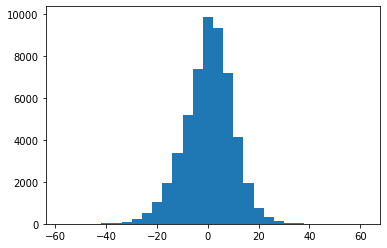

-0.2954483471661959

In [256]:
from scipy.stats import kurtosis, skew
plt.hist(total_residuals, bins=30)
plt.show()
skew(total_residuals)

# Now lets look at inter-player correlations

In [414]:
#we will need these functions for later
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [415]:
nearestPD(np.array([[1,5,0],[0,1,0],[0,0,1]]))

array([[1.75, 1.75, 0.  ],
       [1.75, 1.75, 0.  ],
       [0.  , 0.  , 1.  ]])

In [400]:
def correlate(player1, player2):
    if player1 == player2:
        return 1
    residuals1 = []
    residuals2 = []
    for date in data:
        if player1 in data[date]["PROJECTIONS"] and player2 in data[date]["PROJECTIONS"]:

            #print(player1, player2)
            projected1 = data[date]['PROJECTIONS'][player1]['points']
            actual1 = get_Fpts(data[date]["ACTUAL_POINTS"], player1)
            projected2 = data[date]['PROJECTIONS'][player2]['points']
            actual2 = get_Fpts(data[date]["ACTUAL_POINTS"], player2)
            if actual1 >= 0 and actual2 >= 0:
                #print(date, projected, actual, projected-actual)
                residuals1.append(projected1-actual1)
                residuals2.append(projected2-actual2)
    if len(residuals1) < 20:
        return 0
    #return (residuals1, residuals2), np.corrcoef(residuals1,residuals2)
    return np.corrcoef(residuals1,residuals2)[0][1]

In [375]:
def get_most_recent_team(data, player):
    for date in list(data.keys())[::-1]:
        #print(date)
        if player in data[date]["PROJECTIONS"]:
            return data[date]["PROJECTIONS"][player]['team']

In [376]:
current_player_teams = {}
for player in PLAYERS:
    current_player_teams[player] = get_most_recent_team(data, player)
#get_most_recent_team(data, "LeBron James")
#current_player_teams

In [250]:
arrays, mat = correlate("Ben Simmons", "Al Horford")

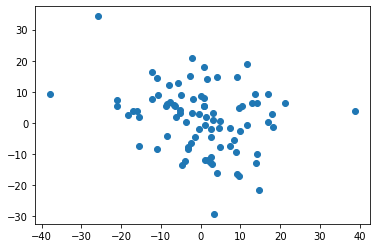

In [251]:
plt.scatter(arrays[0], arrays[1])

In [247]:
mat

array([[ 1.        , -0.07235873],
       [-0.07235873,  1.        ]])

In [249]:
for player1 in PLAYERS:
    print(player1)
    for player2 in {k: v for k, v in current_player_teams.items() if v == current_player_teams[player1]}:
        print(correlate(player1,player2)[1][0][1], player2)

Troy Daniels
1.0 Troy Daniels
-0.02459190094811281 Danny Green
0.04081751278591417 Travis Wear
-0.3970309962823802 Tyler Ennis
nan Scott Machado
0.02512807634493565 Dwight Howard
-0.04472976543284329 Rajon Rondo
-0.18374094099061059 Avery Bradley
0.10997546070296282 Michael Beasley
nan Derrick Williams
-0.03664203825700262 Quinn Cook
0.028307177226033823 Lance Stephenson
-0.009081715455905649 Jared Dudley
nan Vander Blue
0.026426694346908194 JaVale McGee
1.0 Jemerrio Jones
-0.0460807326672738 Kyle Kuzma
-0.0723587296942244 LeBron James
-0.018093457618714167 Anthony Davis
0.013391145335168837 Alex Caruso
-0.12697376460524706 Kentavious CaldwellPope
nan Andre Ingram
Treveon Graham
1.0 Treveon Graham
nan Jaylen Morris
-0.012249342677505515 Trae Young
0.0466872814321777 DeAndre Bembry
-0.06649112094607194 Alex Len
0.9999999999999999 Andrew White
0.11270349449036274 Vince Carter
0.1182867092540823 Dewayne Dedmon
nan Antonius Cleveland
-0.20737168990039914 Malcolm Delaney
nan Jordan Sibert
-

0.043063161274552494 Luke Kornet
-0.23479410398588454 Tomas Satoransky
nan Rawle Alkins
-0.3462755734360447 Wendell Carter
-0.12771701276765593 Cristiano Felicio
-0.03652634108665611 Denzel Valentine
nan Shaq Harrison
nan Brandon Sampson
nan Tyler Ulis
nan Cristiano Da
0.08548751438124148 Zach LaVine
0.13385445377920305 Lauri Markkanen
nan Walter Lemon
Kelan Martin
1.0 Kelan Martin
-0.3387303026093118 Jordan Bell
-0.17460651297906465 KarlAnthony Towns
nan Jared Terrell
-1.0 Jaylen Nowell
0.30517375567271016 Gorgui Dieng
-0.9999999999999997 Malik Beasley
nan Juancho Hernangomez
-0.18281180374215822 James Johnson
-0.9752113171858501 Jordan McLaughlin
nan Luol Deng
-0.3811760558574822 Naz Reid
-0.28274157628151914 Josh Okogie
nan Cole Aldrich
nan Jerryd Bayless
nan CJ Williams
nan Marcus GeorgesHunt
0.04285885358656872 Jarrett Culver
0.7653689843865545 Allen Crabbe
nan Anthony Brown
nan Cameron Reynolds
nan Aaron Brooks
nan Jake Layman
Dorian FinneySmith
0.9999999999999999 Dorian FinneySm

-0.05440441363711136 Cedi Osman
0.09736927598989507 Andre Drummond
0.19283381712563152 Kevin Love
-0.1711254607970249 Alfonzo McKinnie
-0.00011195119584710868 Larry Nance
0.5583477580780863 Ante Zizic
0.49354549309022994 Cameron Payne
0.02566852269302211 Kevin Porter
-0.10777798625119457 Channing Frye
-0.9960583471722291 John Holland
nan London Perrantes
-0.03395341656181788 Collin Sexton
-0.17006233436672086 Tristan Thompson
Matt Costello
nan Dante Cunningham
nan Matt Costello
nan Joffrey Lauvergne
nan Brandon Paul
nan Drew Eubanks
nan Marco Belinelli
nan Trey Lyles
nan Lonnie Walker
nan Chimezie Metu
nan Bryn Forbes
nan Derrick White
nan Darrun Hilliard
nan LaMarcus Aldridge
nan Manu Ginobili
nan Dejounte Murray
nan Patty Mills
nan Rudy Gay
nan Jakob Poeltl
nan DeMarre Carroll
nan Quincy Pondexter
nan DeMar DeRozan
Mike Scott
-0.14748561652283385 Tobias Harris
-0.06497171035594994 Ben Simmons
0.8344784117878014 Zhaire Smith
0.9999999999999999 Mike Scott
-0.10588207501184389 James Enn

-0.012249342677505515 Treveon Graham
nan Jaylen Morris
1.0 Trae Young
0.003560470962936205 DeAndre Bembry
0.1512696313656448 Alex Len
nan Andrew White
0.09033976764879775 Vince Carter
0.2544513581388135 Dewayne Dedmon
nan Antonius Cleveland
nan Malcolm Delaney
nan Jordan Sibert
-0.1511994387709752 Jabari Parker
0.07433649469115626 DeAndre Hunter
-0.2883076768559387 Jaylen Adams
0.023503999354788446 Tyrone Wallace
0.09094412211401973 Kevin Huerter
-0.033834789628991446 Cam Reddish
nan Isaiah Taylor
-0.09121907185811044 Damian Jones
-0.7604006546179314 Daniel Hamilton
-0.07720017764797091 Evan Turner
-0.37617580148186097 Jeff Teague
-0.33517711657801325 Brandon Goodwin
0.047418649049426824 Alex Poythress
nan Charles Brown
0.18574588525081273 Miles Plumlee
-0.01717341035555362 Bruno Fernando
nan Nicolas Brussino
-0.3350381039496302 Deyonta Davis
0.040280341055343324 John Collins
Luc Mbah
nan Luc Mbah
nan Marcus Morris
nan Mfiondu Kabengele
nan Lou Williams
nan Luc Richard
nan Marcin Gorta

-0.5935199170145182 Yuta Watanabe
-0.2212081582120805 Tyus Jones
nan Myke Henry
nan Kobi Simmons
-0.0642217567586819 Kyle Anderson
-0.2079589348214263 MarShon Brooks
nan Xavier RathanMayes
nan Marquis Teague
nan Tyler Zeller
0.9889707096306574 Chandler Parsons
nan Briante Weber
nan Vince Hunter
-0.22942413753259194 Ja Morant
-0.10823303838481128 CJ Miles
Travis Wear
0.04081751278591417 Troy Daniels
0.1891201148352144 Danny Green
0.9999999999999999 Travis Wear
-0.07549461775360981 Tyler Ennis
nan Scott Machado
0.7476833653274341 Dwight Howard
0.401631945047294 Rajon Rondo
nan Avery Bradley
0.07643837785441611 Michael Beasley
nan Derrick Williams
0.04209018947165198 Quinn Cook
0.0637352028804028 Lance Stephenson
-0.18924641761266245 Jared Dudley
nan Vander Blue
-0.139076023668727 JaVale McGee
nan Jemerrio Jones
-0.36252136422278064 Kyle Kuzma
-0.2910922710718695 LeBron James
0.3324394350989288 Anthony Davis
-0.3771608712033609 Alex Caruso
0.5204390629068698 Kentavious CaldwellPope
nan An

0.40541898692130657 Skal Labissiere
-0.04478392500674517 Hassan Whiteside
-0.07119433331449647 Mario Hezonja
-0.556968763699721 Carmelo Anthony
Omari Johnson
nan DeAnthony Melton
1.0 Dillon Brooks
nan Jaren Jackson
1.0 Ivan Rabb
1.0 Omari Johnson
nan Julian Washburn
nan John Konchar
nan Omri Casspi
nan Brandon Clarke
nan Brice Johnson
-0.9999999999999999 Jonas Valanciunas
nan Grayson Allen
nan Josh Jackson
nan Dusty Hannahs
-1.0 Mario Chalmers
nan Marko Guduric
nan Tyler Dorsey
nan Bruno Caboclo
nan Joakim Noah
nan Yuta Watanabe
-1.0 Tyus Jones
-1.0 Myke Henry
1.0 Kobi Simmons
-1.0 Kyle Anderson
-1.0 MarShon Brooks
nan Xavier RathanMayes
nan Marquis Teague
1.0 Tyler Zeller
nan Chandler Parsons
nan Briante Weber
nan Vince Hunter
nan Ja Morant
1.0 CJ Miles
Marcus Morris
nan Luc Mbah
0.9999999999999998 Marcus Morris
nan Mfiondu Kabengele
0.009566569081447606 Lou Williams
-0.005467932304608279 Luc Richard
0.08986324757735237 Marcin Gortat
0.08674226778137752 JaMychal Green
0.31288225899142

-0.22592598206263678 Trey Lyles
nan Lonnie Walker
nan Chimezie Metu
0.10046493343787333 Bryn Forbes
nan Derrick White
-0.9079440166829009 Darrun Hilliard
-0.4861171233124587 LaMarcus Aldridge
-0.02082127051569927 Manu Ginobili
-0.039985198934163274 Dejounte Murray
-0.09090289396065052 Patty Mills
-0.025749281601131716 Rudy Gay
0.3479992180325233 Jakob Poeltl
-0.2529254709036911 DeMarre Carroll
0.33041963164744415 Quincy Pondexter
0.253997819057401 DeMar DeRozan
Iman Shumpert
0.2522411557790243 DeAndre Jordan
nan Mitch Creek
0.39903793354537714 Timothe LuwawuCabarrot
1.0 Iman Shumpert
-0.9999999999999999 Isaiah Whitehead
-0.44076563085897363 Wilson Chandler
0.3690535207184617 Theo Pinson
nan Nicolas Claxton
nan Yakuba Ouattara
0.13479356795856373 Caris LeVert
nan James Webb
-0.8028537036854589 Dzanan Musa
0.09439811077555876 Timofey Mozgov
-0.174221680761305 Garrett Temple
-0.04550954489695556 Jarrett Allen
0.32124319630837134 Kyrie Irving
0.2161031445087415 Taurean Prince
0.01527472799

0.26449475566152003 Lonzo Ball
nan Zylan Cheatham
1.0 Ian Clark
0.08371878656422323 DeAndre Liggins
-0.0651958202142489 Tony Allen
-0.027716267256388524 Emeka Okafor
nan Zion Williamson
nan Jaxson Hayes
0.3367879486922997 Larry Drew
0.4002851767808115 Mike James
-0.9419067598019242 Josh Smith
nan Nickeil AlexanderWalker
0.051460902167061943 Brandon Ingram


KeyboardInterrupt: 

In [248]:
{k: v for k, v in current_player_teams.items() if v == current_player_teams["Draymond Green"]}

{'Draymond Green': 'GSW',
 'Jonas Jerebko': 'GSW',
 'Andrew Wiggins': 'GSW',
 'Stephen Curry': 'GSW',
 'Ky Bowman': 'GSW',
 'DeMarcus Cousins': 'GSW',
 'David West': 'GSW',
 'Andrew Bogut': 'GSW',
 'Marquese Chriss': 'GSW',
 'Jacob Evans': 'GSW',
 'Alen Smailagic': 'GSW',
 'Klay Thompson': 'GSW',
 'DAngelo Russell': 'GSW',
 'Marcus Derrickson': 'GSW',
 'Jordan Poole': 'GSW',
 'Shaun Livingston': 'GSW',
 'Eric Paschall': 'GSW',
 'Kevon Looney': 'GSW',
 'Damion Lee': 'GSW',
 'Kevin Durant': 'GSW',
 'Omari Spellman': 'GSW'}

In [242]:
for player1 in ["LeBron James"]:
    print(player1)
    for player2 in {k: v for k, v in current_player_teams.items() if v == current_player_teams[player1]}:
        print(correlate(player1,player2)[1][0][1], player2)

LeBron James
-0.07235872969422441 Troy Daniels
-0.029540056046122972 Danny Green
-0.29109227107186947 Travis Wear
0.20060253184747426 Tyler Ennis
nan Scott Machado
-0.10545753163878423 Dwight Howard
-0.20820534829541065 Rajon Rondo
0.1696204291979509 Avery Bradley
0.14234178161072036 Michael Beasley
nan Derrick Williams
-0.1266436742961806 Quinn Cook
-0.18467414514099012 Lance Stephenson
0.09686810820383877 Jared Dudley
1.0 Vander Blue
0.07163222247633312 JaVale McGee
nan Jemerrio Jones
0.16181730807462053 Kyle Kuzma
1.0 LeBron James
-0.33010577181642164 Anthony Davis
-0.19344912635236722 Alex Caruso
-0.05761477652559605 Kentavious CaldwellPope
1.0 Andre Ingram


In [244]:
correlate("LeBron James", "Andre Ingram")

(([12.490000000000002, 3.8800000000000026], [4.52, -0.6200000000000001]),
 array([[1., 1.],
        [1., 1.]]))

In [253]:

slope, intercept, r_value, p_value, std_err = stats.linregress(arrays[0], arrays[1])

In [254]:
print(slope, intercept, r_value, p_value, std_err)

-0.230950969728548 1.3014531093108075 -0.25618238027779444 0.01727268560285807 0.09508028399416836


# Payout per Points explorations

In [26]:
sum_payout_return

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [11]:
sum_payout_return = [[] for i in range(450)]
num_contests = [0 for i in range(450)]
for date in list(data.keys())[-100:]:
    #print(data[date]['CONTESTS'][0].keys())
    #data[date]['CONTESTS'][0]['PAYOUTS']
    #break
    print(date)
    for contest in data[date]['CONTESTS']:
        for val in range(450):
            #print(get_payout(contest['PAYOUTS'], 1))
            sum_payout_return[val] += [(get_payout(contest['PAYOUTS'], val)/float(contest['Buy In'][1:])-1)]
            num_contests[val] +=1
    #break

2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2019-04-06
2019-04-07
2019-04-09
2019-04-10
2019-10-22
2019-10-23
2019-10-24
2019-10-25
2019-10-26
2019-10-27
2019-10-28
2019-10-29
2019-10-30
2019-10-31
2019-11-01
2019-12-01
2019-12-02
2019-12-03
2019-12-04
2019-12-05
2019-12-06
2019-12-07
2019-12-08
2019-12-09
2019-12-10
2019-12-11
2019-12-12
2019-12-13
2019-12-14
2019-12-15
2019-12-16
2019-12-17
2019-12-18
2019-12-19
2019-12-20
2019-12-21
2019-12-22
2019-12-23
2019-12-25
2019-12-26
2019-12-27
2019-12-28
2019-12-29
2019-12-30
2019-12-31
2020-01-01
2020-01-02
2020-01-03
2020-01-04
2020-01-05
2020-01-06
2020-01-07
2020-01-08
2020-01-10
2020-01-11
2020-01-12
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-18
2020-01-19
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-25
2020-01-26
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31

In [12]:
sum_payout_return

[[-1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,


In [17]:
len(sum_payout_return)

450

In [18]:
payouts = np.array([sum(sum_payout_return[i]) for i in range(len(sum_payout_return))])/np.array(num_contests)

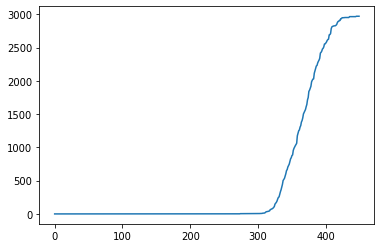

In [19]:
plt.plot(payouts)

In [8]:
data['2017-11-01']['PROJECTIONS']

{'Mario Chalmers': {'ceil': 28.35,
  'floor': 28.35,
  'points': 28.35,
  'salary': 3600.0,
  'team': 'MEM'},
 'Tyreke Evans': {'ceil': 33.17,
  'floor': 33.17,
  'points': 33.17,
  'salary': 5300.0,
  'team': 'MEM'},
 'Dennis Schroder': {'ceil': 43.64,
  'floor': 43.64,
  'points': 43.64,
  'salary': 7000.0,
  'team': 'ATL'},
 'Mike Muscala': {'ceil': 22.64,
  'floor': 22.64,
  'points': 22.64,
  'salary': 3700.0,
  'team': 'ATL'},
 'Jarrett Jack': {'ceil': 28.62,
  'floor': 28.62,
  'points': 28.62,
  'salary': 4700.0,
  'team': 'NYK'},
 'Jason Smith': {'ceil': 22.32,
  'floor': 22.32,
  'points': 22.32,
  'salary': 3700.0,
  'team': 'WAS'},
 'Jonas Valanciunas': {'ceil': 29.34,
  'floor': 29.34,
  'points': 29.34,
  'salary': 4900.0,
  'team': 'TOR'},
 'Bojan Bogdanovic': {'ceil': 23.88,
  'floor': 23.88,
  'points': 23.88,
  'salary': 4000.0,
  'team': 'IND'},
 'Dillon Brooks': {'ceil': 22.97,
  'floor': 22.97,
  'points': 22.97,
  'salary': 3900.0,
  'team': 'MEM'},
 'Marc Gasol':

In [55]:
vals = []
for date in list(data.keys())[-100:]:
    for i in range(10):
        projs = data[date]["PROJECTIONS"]
        #print(data[date].keys())
        results = data[date]["ACTUAL_POINTS"]

        candidates = set(projs.keys()).intersection(results.Player)
        sample = random.sample(candidates, 8)
        predicted_points = sum([projs[p]["points"] for p in sample])
        predicted_variance = (sum([player_data[p]["std"]**2 for p in sample]))**.5
        actual_points = sum([get_Fpts(results,p) for p in sample])
        resid = (actual_points-predicted_points)/predicted_variance
        vals.append( resid)
        print(date, len(candidates), predicted_points, predicted_variance, actual_points, resid)

2019-03-21 116 235.39999999999998 30.596298494035757 198.25 -1.2141991622693102
2019-03-21 116 190.46 27.749367438726004 190.25 -0.00756774007420939
2019-03-21 116 175.83999999999997 25.70146361740715 170.0 -0.22722441363396306
2019-03-21 116 144.79000000000002 25.166619486995526 149.25 0.17721887527661861
2019-03-21 116 192.16 26.574212930517188 159.25 -1.2384186160489044
2019-03-21 116 215.31999999999996 26.674593179699 188.75 -0.9960789212793455
2019-03-21 116 167.36000000000004 26.70849864435747 153.75 -0.5095756291368829
2019-03-21 116 154.61 24.885953976204526 151.0 -0.14506174862542245
2019-03-21 116 167.41 26.87736485301417 147.75 -0.7314705183159063
2019-03-21 116 160.03 26.776581699533082 202.0 1.567414409761342
2019-03-22 138 127.17999999999999 24.337480585464647 108.75 -0.7572681952546539
2019-03-22 138 175.14 26.02098785354136 187.0 0.45578592429902354
2019-03-22 138 166.84999999999997 24.478639475748896 228.0 2.498096352968539
2019-03-22 138 218.54000000000002 28.82792587

2019-04-01 178 208.45 32.94265553653019 188.75 -0.5980088635585135
2019-04-02 78 132.89 25.00724325360645 153.75 0.8341583191898476
2019-04-02 78 175.93999999999997 27.490462130499928 196.5 0.747895757532183
2019-04-02 78 162.94 26.27576809693964 159.0 -0.14994804283034044
2019-04-02 78 153.95999999999998 23.699597125782876 175.25 0.8983275068772605
2019-04-02 78 222.40999999999997 26.760425309837316 222.25 -0.00597897821680551
2019-04-02 78 212.74999999999997 28.489548272932804 212.75 9.976188164909146e-16
2019-04-02 78 186.58 28.02178982261814 150.5 -1.2875694318025892
2019-04-02 78 214.20000000000002 27.51811446824774 181.25 -1.1973930858533186
2019-04-02 78 156.57 24.142685872941453 130.5 -1.07983014554394
2019-04-02 78 196.71999999999997 27.370735832753457 163.5 -1.2137050389506494
2019-04-03 234 177.04 26.975717937937766 147.75 -1.0857913056248076
2019-04-03 234 189.48999999999998 26.390356213905605 198.0 0.3224662801450149
2019-04-03 234 148.88 22.810767701738868 129.25 -0.86055

2019-10-26 179 185.52 26.552737358959217 212.0 0.9972606455607228
2019-10-26 179 204.7 28.495317212991118 209.0 0.15090198743390812
2019-10-27 79 142.83 27.57303714171745 131.25 -0.419975497819923
2019-10-27 79 163.96999999999997 27.504315583529753 151.75 -0.44429391318203176
2019-10-27 79 200.31 27.62363666418184 265.5 2.3599354709341562
2019-10-27 79 130.17000000000002 23.910974129907242 114.0 -0.6762585209682022
2019-10-27 79 199.92 27.101150316860238 202.75 0.10442361179921597
2019-10-27 79 183.39000000000001 27.680795740907794 192.25 0.3200775036573938
2019-10-27 79 243.68999999999997 30.713598605957316 254.75 0.36010107906583094
2019-10-27 79 225.3 30.09645585164096 213.0 -0.40868599481056084
2019-10-27 79 234.45999999999998 27.242097087382394 223.75 -0.39314153993528217
2019-10-27 79 196.93 27.758925680791506 166.75 -1.0872178681210212
2019-10-28 218 145.41 25.788736065882052 138.5 -0.2679464391875249
2019-10-28 218 150.32 26.98098145066581 171.75 0.7942631753105178
2019-10-28 2

2019-12-08 118 177.59 28.19288992186517 193.5 0.5643266810920614
2019-12-08 118 200.96 29.553534759394964 172.25 -0.9714573987083965
2019-12-08 118 197.48000000000002 27.710022505196996 233.5 1.2998906801048051
2019-12-08 118 195.17999999999998 26.81141918395991 230.25 1.3080247546530792
2019-12-08 118 175.66 28.36766835391439 164.5 -0.3934056144751866
2019-12-08 118 156.53 27.0518829367025 171.75 0.5626225736527324
2019-12-09 185 183.93 27.143670864383573 191.75 0.2880966262474456
2019-12-09 185 193.04 26.188435827183 173.0 -0.7652232509128678
2019-12-09 185 153.25 23.33328099561303 140.75 -0.5357154873483145
2019-12-09 185 206.42 28.727834692340917 226.0 0.681568945578074
2019-12-09 185 157.64 26.98255890624266 217.5 2.2184700942559923
2019-12-09 185 160.07 24.985860593628487 161.25 0.04722671030594449
2019-12-09 185 233.84999999999997 28.870869758677333 175.5 -2.021068311683353
2019-12-09 185 228.89999999999998 30.01712547025217 171.5 -1.9122417320367673
2019-12-09 185 166.890000000

2019-12-22 82 178.43999999999997 23.790402599680345 189.25 0.4543849123488678
2019-12-22 82 149.34 23.936530292389218 158.0 0.36179011302876685
2019-12-22 82 217.12 27.12247774088045 258.0 1.5072369268971129
2019-12-22 82 159.0 25.337319222793003 142.25 -0.6610801976608479
2019-12-22 82 134.57 26.336915282462126 143.25 0.32957542320000016
2019-12-22 82 209.21 28.98233375329562 213.75 0.1566471505933763
2019-12-22 82 184.75999999999996 25.76725755818095 153.5 -1.21316752197694
2019-12-22 82 215.54000000000002 28.967635914226413 244.75 1.0083667195518202
2019-12-22 82 183.0 29.7451741522266 156.75 -0.8824960938423363
2019-12-22 82 178.68000000000004 26.454683407825264 199.25 0.777556082712953
2019-12-23 219 196.68 27.596168596607452 161.25 -1.2838738782149495
2019-12-23 219 234.07999999999998 29.55339010178641 208.25 -0.8740114048181106
2019-12-23 219 181.78999999999996 26.761505022009317 208.0 0.9793918532774705
2019-12-23 219 243.29000000000002 26.93797958706869 235.25 -0.2984633637431

2020-01-05 84 195.66 29.34721531147752 167.75 -0.9510271998135565
2020-01-05 84 143.46 22.628586508767725 163.5 0.8856054704183687
2020-01-05 84 190.01 28.558524038929743 233.5 1.5228378028471052
2020-01-05 84 92.28999999999998 22.320603779122997 90.25 -0.09139537712272995
2020-01-05 84 166.73000000000002 28.29350528974727 196.25 1.043348984075761
2020-01-05 84 164.23000000000002 27.074942690918704 148.25 -0.5902136223305811
2020-01-05 84 199.64999999999998 30.17929560762413 189.25 -0.34460711526257914
2020-01-05 84 154.20999999999998 26.07895909549096 146.5 -0.29564063395969803
2020-01-05 84 186.83999999999997 31.302240004042403 175.0 -0.37824769085122806
2020-01-06 181 202.24 25.685293979677752 188.25 -0.5446696468052467
2020-01-06 181 218.72 26.302052598895695 223.75 0.19123982742743006
2020-01-06 181 174.82999999999998 27.339172108690093 190.5 0.5731702458912102
2020-01-06 181 226.34000000000003 27.21590984187389 218.5 -0.2880667978969255
2020-01-06 181 248.48000000000002 28.213106

2020-01-18 178 228.26999999999998 29.63666776330926 222.25 -0.20312674987883939
2020-01-18 178 125.78999999999999 25.69711779264244 136.75 0.4265069759355681
2020-01-18 178 231.78000000000003 26.367226059367546 198.75 -1.252691501397637
2020-01-18 178 182.3 25.51733611834887 208.25 1.016955683761206
2020-01-18 178 220.25000000000003 29.539377092732153 204.0 -0.5501131573962055
2020-01-18 178 206.83999999999997 25.430090764944453 201.75 -0.20015658013366486
2020-01-18 178 136.54 24.14581380540921 92.5 -1.8239186450669156
2020-01-18 178 182.40999999999997 24.391820321677354 161.75 -0.8470052553494393
2020-01-18 178 256.91 28.789607451565555 222.75 -1.1865392766285332
2020-01-18 178 188.85 22.981831346545654 170.5 -0.7984568210991654
2020-01-19 40 189.82999999999998 27.707671056034357 166.0 -0.8600506318920706
2020-01-19 40 167.60000000000002 27.93253766823131 179.75 0.4349765905379451
2020-01-19 40 165.88 27.30753770043244 125.75 -1.4695576159312416
2020-01-19 40 211.44 28.77307196381638

2020-01-31 137 206.64 28.330641740379928 239.5 1.1598748909794143
2020-01-31 137 182.26 25.970114197942767 178.0 -0.1640347041807559
2020-01-31 137 178.35999999999999 25.23207828671841 185.75 0.29288114581865193
2020-01-31 137 205.63 27.289378284468274 148.75 -2.084327440774757
2020-01-31 137 193.6 25.697328694795722 147.75 -1.7842321489737427
2020-01-31 137 147.24 26.781846914581212 151.5 0.15906296580616552
2020-01-31 137 219.57 29.363523039559205 194.0 -0.8708083143004165
2020-01-31 137 151.2 25.778398716149596 120.0 -1.2103156733491705
2020-01-31 137 129.6 25.94410176100161 166.0 1.4030163902114887
2020-02-01 176 197.1 27.502429033748623 169.75 -0.994457615596005
2020-02-01 176 191.94000000000003 29.18726019748255 178.25 -0.46904025617247935
2020-02-01 176 179.84 26.833182522111308 125.75 -2.015787726835171
2020-02-01 176 186.74 27.977279236253775 201.75 0.5365067801357036
2020-02-01 176 168.19000000000003 26.37136780350167 192.5 0.9218331101040583
2020-02-01 176 191.46000000000004

(array([ 20., 184., 385., 305.,  75.,  19.,   2.,   4.,   2.,   4.]),
 array([-3.06955544, -2.02002148, -0.97048751,  0.07904646,  1.12858043,
         2.17811439,  3.22764836,  4.27718233,  5.32671629,  6.37625026,
         7.42578423]),
 <a list of 10 Patch objects>)

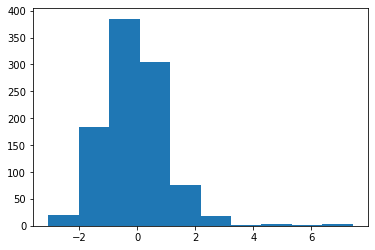

In [56]:
plt.hist(vals)

In [51]:
np.std(vals)

1.1764087240961487

In [52]:
np.mean(vals)

-0.10508790728154224

# Now lets examine what will happen if we generate our top lineups

In [234]:
# some important helper functions

def add_position_requirement(prob,example_results, example_projections, choices, pos, number):
    players = list(example_projections.keys())
    POS = list(example_results[example_results.apply(lambda x: pos in x['Pos'].split('/'), axis=1)].Player)
    POS = [re.sub(r'([^\s\w]|_)+', '', a) for a in POS]
    POS = [name.split()[0]+ " " + name.split()[1] for name in POS]
    prob += lpSum([choices[v] for v in POS if v in players]) >= number

def add_all_position_requirements(prob, results, projections, choices):
    add_position_requirement(prob, results, projections,choices, 'C',1)
    add_position_requirement(prob, results, projections,choices,  'PG', 1)
    add_position_requirement(prob, results, projections,choices, 'SG', 1)
    add_position_requirement(prob, results, projections,choices, 'PF', 1)
    add_position_requirement(prob, results, projections,choices, 'SF', 1)
    add_position_requirement(prob, results, projections,choices, 'F', 2)
    add_position_requirement(prob, results, projections,choices, 'G', 2)
    
def get_Fpts(df, player):
    df = df[df['Player'] == player]
    #print(df)
    #print(player)
    try:
        return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    except:
        #print("??? {}".format(player))
        return 0
def get_payout(df, points):
    df = df[df['Points'] < points]
    if df.empty:
        return 0
    try:
        return float(df.iloc[0].Prize[1:].replace(",",""))
    except:
        return 0

In [241]:
# uses linear algebra to return a random lineup that satisfies certain constraints
def get_max_ev(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points']-np.mean(player_data[name]["mean"]) for name in players]), "Total Projection"
    prob.solve()
    return(value(prob.objective))
# uses linear algebra to return a random lineup that satisfies certain constraints
def get_max_var(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                       [(projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]), "Total Variance"
    
    prob.solve()
    return(value(prob.objective))

def get_random_lineup(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = set(projections.keys()).intersection(results.Player)
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(100) for name in players]), "Total Projection"
    prob.solve()
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print(pulp.lpDot([choices[v].varValue for v in players],
                    [projections[name]['points'] for name in players]))
    return [player for player in players if (choices[player].varValue == 1)]
    #return(value(prob.objective))
def get_random_lineup_actual(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = list(set(projections.keys()).intersection(list(results.Player)))
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(example_projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(2) for name in players]), "Total Projection"
    prob.solve()
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print((pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])))
    print(pulp.lpDot([choices[v].varValue for v in players],[example_projections[name]['points'] for name in players]))
    print([choices[v] for v in players if choices[v].varValue == 1])
    #return(value(prob.objective))
    #return prob
    return(pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])).value()

def get_random_payout(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    global example_contest
    points = get_random_lineup_actual(results, projections,
                                      optimal_variance_ratio=optimal_variance_ratio, optimal_expected_ratio=optimal_expected_ratio)
    payout = get_payout(example_contest, points) - float(COST[1:])
    return payout

In [144]:
get_random_lineup(data['2019-02-01']['ACTUAL_POINTS'], data['2019-02-01']['PROJECTIONS'])

259.83000000000004


['Mario Hezonja',
 'Jerami Grant',
 'Kemba Walker',
 'Ricky Rubio',
 'John Collins',
 'Tyler Johnson',
 'Kyrie Irving',
 'JaMychal Green']

In [96]:
vals = []
payouts = []
for date in list(data.keys())[-100:]:
    for i in range(10):
        projs = data[date]["PROJECTIONS"]
        #print(data[date].keys())
        results = data[date]["ACTUAL_POINTS"]
        contest = data[date]["CONTESTS"][0]

        candidates = set(projs.keys()).intersection(results.Player)
        sample = set(get_random_lineup(results,projs))
        #sample = random.sample(candidates, 8)
        predicted_points = sum([projs[p]["points"] for p in sample])
        predicted_variance = (sum([player_data[p]["std"]**2 for p in sample]))**.5
        actual_points = sum([get_Fpts(results,p) for p in sample])
        resid = (actual_points-predicted_points)/predicted_variance
        vals.append(resid)
        payout = get_payout(contest["PAYOUTS"], actual_points) - float(contest["Buy In"][1:])
        payouts.append(payout)
        print(date, len(candidates), predicted_points, predicted_variance, actual_points, resid)

283.47
2019-03-21 116 283.46999999999997 31.177887635558402 226.5 -1.8272565693329925
283.2
2019-03-21 116 283.2 31.2942001657822 249.5 -1.0768768596568365
284.76
2019-03-21 116 284.76 30.86818675637999 240.0 -1.4500365814570813
283.08000000000004
2019-03-21 116 283.08 31.15186783147423 257.75 -0.8131133624805594
283.31
2019-03-21 116 283.31 31.73312024866685 258.75 -0.7739547768244379
281.62
2019-03-21 116 281.62 31.61320330004672 234.75 -1.4826083758468962
280.82
2019-03-21 116 280.82000000000005 31.5493682049587 207.75 -2.316052718561744
280.93999999999994
2019-03-21 116 280.93999999999994 31.21770247329872 202.5 -2.5126769039807346
285.08000000000004
2019-03-21 116 285.08 31.74078672415393 255.0 -0.9476765734073589
282.78
2019-03-21 116 282.78 31.695058343042806 215.0 -2.1385037145665313
269.77
2019-03-22 138 269.77 29.998110757001868 263.0 -0.2256808788673398
277.6
2019-03-22 138 277.6 28.9478019752683 286.5 0.3074499406761086
273.53
2019-03-22 138 273.53 29.707480578583176 272.5 

271.01
2019-03-31 76 271.01000000000005 29.894546730876094 220.25 -1.6979685444627737
274.1
2019-03-31 76 274.1 30.175994597077576 225.75 -1.6022669888959526
274.63
2019-03-31 76 274.63 28.607562386752964 235.0 -1.3852980363804464
271.03000000000003
2019-03-31 76 271.03000000000003 29.60967074986147 220.0 -1.7234234190273385
267.83
2019-03-31 76 267.83 29.731591384805306 255.0 -0.43152752350003415
270.22
2019-03-31 76 270.22 29.93935444056707 207.5 -2.0949015492136334
267.85
2019-03-31 76 267.85 29.824067640405335 205.25 -2.098975926247907
279.69
2019-04-01 178 279.69 30.191290465566663 294.75 0.49881935378602044
280.04
2019-04-01 178 280.04 30.18453646696174 301.0 0.6943952915408057
279.49
2019-04-01 178 279.48999999999995 30.299921597906987 283.5 0.13234357676612088
278.42
2019-04-01 178 278.41999999999996 29.28756018618293 272.0 -0.21920569549623117
287.88
2019-04-01 178 287.88 29.761827798723278 277.75 -0.3403688801812956
278.74
2019-04-01 178 278.74 30.468373589765093 286.25 0.246

274.53999999999996
2019-10-22 42 274.54 29.71628996904287 295.25 0.6969241456983611
268.54
2019-10-22 42 268.53999999999996 29.42542647844909 276.25 0.2620182924331367
262.43000000000006
2019-10-22 42 262.43 30.086429568572218 277.25 0.49258088156398316
270.98
2019-10-22 42 270.98 28.57541750340284 243.5 -0.961665739327435
267.58
2019-10-22 42 267.58000000000004 29.96460277296037 314.25 1.5575043778692872
265.02
2019-10-23 223 265.02 29.444070212778183 244.25 -0.7054051919420496
264.44
2019-10-23 223 264.44 29.751715517463555 211.5 -1.77939319058511
263.4
2019-10-23 223 263.40000000000003 29.895092569288582 255.0 -0.28098257199007326
267.59000000000003
2019-10-23 223 267.59000000000003 28.912233024677853 238.5 -1.006148503824331
266.65
2019-10-23 223 266.65000000000003 29.80087913619918 225.25 -1.3892207612664482
263.81
2019-10-23 223 263.81000000000006 30.05372163291406 257.25 -0.21827579559450358
268.92999999999995
2019-10-23 223 268.93 28.8968277186867 274.25 0.1841032535401701
267.

267.20000000000005
2019-11-01 163 267.2 31.488134918116067 191.75 -2.3961406477775014
262.73
2019-11-01 163 262.73 32.445302661485364 246.5 -0.5002264940886515
250.13
2019-12-01 79 250.13 25.677736907264705 224.25 -1.0078769828301366
248.83999999999997
2019-12-01 79 248.83999999999997 27.359653115746646 266.5 0.6454760199366688
248.3
2019-12-01 79 248.3 28.004582185983203 255.25 0.24817367221706269
238.97999999999996
2019-12-01 79 238.98000000000002 26.246480158133274 222.0 -0.6469438910549782
250.64
2019-12-01 79 250.64 28.10786018342754 244.25 -0.22733854367781242
238.37
2019-12-01 79 238.37000000000006 28.017495946214805 205.25 -1.1821184899457302
241.25000000000003
2019-12-01 79 241.25 28.432028086126234 217.25 -0.844118468344898
241.8
2019-12-01 79 241.8 26.038037118200684 247.75 0.2285118487614766
244.27
2019-12-01 79 244.26999999999998 29.171848812067825 174.5 -2.3916893457619146
248.95000000000005
2019-12-01 79 248.95 25.966179451424026 248.0 -0.03658605232152815
277.96
2019-12

283.65
2019-12-11 224 283.65 31.06616489552328 313.5 0.9608524290135823
274.7
2019-12-11 224 274.7 29.596346263410915 263.0 -0.39531906728853056
275.21
2019-12-11 224 275.21 29.13184855517122 271.75 -0.1187703551817961
276.49
2019-12-11 224 276.49 29.8329416469045 284.0 0.25173514864496227
279.50000000000006
2019-12-11 224 279.5 30.71017169641069 246.0 -1.0908437872366366
286.13
2019-12-11 224 286.13000000000005 28.825678679634567 284.25 -0.06521962660078766
284.42
2019-12-11 224 284.42 31.565616572158277 289.0 0.1450945838339704
274.91
2019-12-11 224 274.91 29.171290404847742 311.0 1.2371753014396123
273.71000000000004
2019-12-11 224 273.71 30.00052369791639 238.25 -1.1819793666622815
275.43
2019-12-11 224 275.43000000000006 29.501173450163865 230.25 -1.5314645051771358
256.39000000000004
2019-12-12 82 256.39000000000004 31.495505886913232 242.5 -0.4410153007185545
241.9
2019-12-12 82 241.9 32.52605904546725 259.75 0.5487907396050652
253.73000000000005
2019-12-12 82 253.73 32.21419893

281.01
2019-12-21 147 281.01 29.671646788275858 218.5 -2.1067249973027966
274.28
2019-12-21 147 274.28 27.35292069742141 263.25 -0.4032476137380014
279.01000000000005
2019-12-21 147 279.01 28.99812839874992 273.25 -0.19863350905944324
288.32
2019-12-21 147 288.32 30.17252082803506 255.75 -1.0794590278230016
274.89
2019-12-21 147 274.89000000000004 30.263040207886263 222.5 -1.7311545581711814
276.97
2019-12-21 147 276.96999999999997 29.26397349723821 273.0 -0.1356616865571806
268.53
2019-12-22 82 268.53 27.46595664391966 292.5 0.8727167347839836
267.52
2019-12-22 82 267.52 29.45575394840845 254.0 -0.45899351358244533
271.02000000000004
2019-12-22 82 271.02000000000004 28.05825691806507 278.75 0.27549822580115685
273.40999999999997
2019-12-22 82 273.41 30.3656705006382 274.75 0.044128780228047726
267.61
2019-12-22 82 267.61 27.854508905500953 283.5 0.5704641950036997
269.31
2019-12-22 82 269.31 27.02985692739151 274.25 0.18276086378370363
277.44
2019-12-22 82 277.44 27.841519293517432 28

265.38000000000005
2020-01-01 82 265.38 28.4054213783114 277.0 0.4090768394258819
260.05
2020-01-01 82 260.05 28.76375221429393 272.25 0.42414494149123183
265.54
2020-01-01 82 265.53999999999996 31.221458146500677 309.5 1.4080059872196298
267.92
2020-01-01 82 267.92 30.274640338939047 268.5 0.019157948484494192
268.55
2020-01-01 82 268.55 28.554570033922147 268.25 -0.010506199170347112
265.46999999999997
2020-01-02 177 265.46999999999997 30.38241710920713 261.75 -0.1224392380181186
264.97999999999996
2020-01-02 177 264.98 27.741814256510594 275.25 0.37019929212415387
264.52
2020-01-02 177 264.52 29.077143264936407 255.0 -0.32740492809965877
264.14
2020-01-02 177 264.14 30.22510051754941 234.5 -0.9806419000257848
264.52
2020-01-02 177 264.52 30.257257517359406 236.5 -0.926058813622621
266.83
2020-01-02 177 266.83 28.541686694993377 241.75 -0.87871471185336
268.69
2020-01-02 177 268.69 29.977645101876625 256.0 -0.4233154391171838
267.19
2020-01-02 177 267.19 29.183013322826493 262.0 -0.1

266.75
2020-01-12 102 266.75 30.85514013541009 263.25 -0.11343328808879131
271.58
2020-01-12 102 271.58000000000004 30.42744741752922 258.5 -0.42987503422533785
284.96
2020-01-13 140 284.96 30.86448678719491 299.25 0.4629916608860858
287.17
2020-01-13 140 287.16999999999996 30.216415070898723 265.75 -0.7088862113437624
289.33
2020-01-13 140 289.33000000000004 30.91045749317767 243.0 -1.4988454962281181
287.22999999999996
2020-01-13 140 287.23 30.185914714678088 270.75 -0.5459499954124801
291.65999999999997
2020-01-13 140 291.65999999999997 31.50182113759049 287.5 -0.13205585740044481
286.78999999999996
2020-01-13 140 286.78999999999996 28.72186561741519 280.25 -0.22770108624261878
287.07
2020-01-13 140 287.07000000000005 29.751047316615697 286.5 -0.01915898939402076
288.72
2020-01-13 140 288.72 29.634713147231714 292.75 0.13598916851254994
293.85
2020-01-13 140 293.85 29.516357898077352 299.25 0.18294940109639085
292.78999999999996
2020-01-13 140 292.79 29.578061519271152 295.5 0.09162

284.36
2020-01-22 235 284.36 29.896004769482683 301.25 0.5649584327482113
285.55
2020-01-22 235 285.55 31.970762812588863 252.0 -1.049396293628293
265.62
2020-01-23 60 265.62 32.07056919589022 222.5 -1.344534914133228
276.7
2020-01-23 60 276.7 31.300703320648637 207.5 -2.210812942159984
274.19
2020-01-23 60 274.19 32.340578167527575 240.0 -1.0571857999226923
269.95
2020-01-23 60 269.95 30.47342055674749 246.75 -0.7613191947650587
272.58
2020-01-23 60 272.58 32.57459688708542 218.25 -1.6678640778986815
269.36
2020-01-23 60 269.36 32.001210689076 228.75 -1.2690144880631886
271.90000000000003
2020-01-23 60 271.9 31.977141079925868 220.75 -1.5995801460847343
268.16
2020-01-23 60 268.15999999999997 31.080158496151114 222.25 -1.4771481942630809
262.83000000000004
2020-01-23 60 262.83 28.7789980331419 271.25 0.29257446664069203
260.13
2020-01-23 60 260.13 29.56218247605373 265.5 0.18165099969699017
278.89
2020-01-24 197 278.89000000000004 31.571395948321623 231.5 -1.501042275025516
280.96
202

279.5
2020-02-02 58 279.5 29.81820672023279 305.75 0.8803346306600113
274.94
2020-02-02 58 274.94 29.874876449633003 301.0 0.8723048627141732
271.81
2020-02-02 58 271.80999999999995 30.339974846496855 275.5 0.12162172245261808
268.79
2020-02-02 58 268.79 30.00031522480473 245.5 -0.7763251761015992
271.94
2020-02-02 58 271.94 30.39979535954788 248.25 -0.7792815615964175
269.32
2020-02-02 58 269.32 29.368578762023116 234.25 -1.194133372410566
269.83
2020-02-02 58 269.83000000000004 30.248016457689417 286.75 0.5593755221492775
269.75
2020-02-02 58 269.75 30.671105339555243 301.0 1.018874267948152
275.53
2020-02-03 197 275.53 29.62553929467121 280.75 0.17619932410610856
277.07
2020-02-03 197 277.07 28.72609406289607 240.75 -1.2643556732940089
275.21
2020-02-03 197 275.21 31.39646628800763 293.75 0.5905123153009632
280.69000000000005
2020-02-03 197 280.69 28.014742879518884 240.75 -1.425677907227893
276.76
2020-02-03 197 276.76 28.82753850913523 290.25 0.46795531972752824
277.96
2020-02-03 

(array([ 11., 127., 349., 354., 130.,  19.,   0.,   1.,   4.,   5.]),
 array([-3.61062672, -2.52866446, -1.44670221, -0.36473995,  0.71722231,
         1.79918457,  2.88114683,  3.96310909,  5.04507135,  6.12703361,
         7.20899587]),
 <a list of 10 Patch objects>)

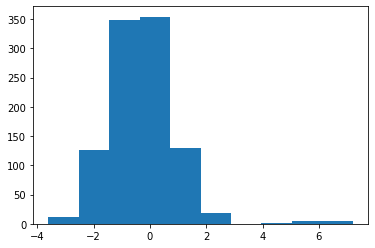

In [91]:
plt.hist(vals)

In [92]:
np.std(vals)

1.1966346738919023

In [93]:
np.mean(vals)

-0.2848902190351017

In [94]:
data["2019-02-01"]["CONTESTS"]

[{'Name': 'NBA $400K Friday Shootaround [$100K to 1st]',
  'Link': 'Contest',
  'Prize Pool': '$400,000',
  'Buy In': '$12',
  'Top Prize': '$100,000',
  'Max Entries': 150,
  'Entries': 39216,
  'Cash Line': 286.75,
  'Winner': 'marques5450',
  'Winning Score': 352.0,
  'PAYOUTS':     Rank              User  Points Entries     Prize
  0      1       marques5450  352.00       4  $100,000
  1      2          mrminwoo  351.75       3   $40,000
  2      3   F0rsaken Member  348.75      60   $20,000
  3      4   sbaugh25 Member  348.50       5    $7,500
  4      4  hanners87 Member  348.50       2    $7,500
  ..   ...               ...     ...     ...       ...
  45  8169         Anonymous  286.50     100       ---
  46  8169         Anonymous  286.50       2       ---
  47  8169         Anonymous  286.50       8       ---
  48  8169         Anonymous  286.50       1       ---
  49  8169         Anonymous  286.50     150       ---
  
  [8300 rows x 5 columns]},
 {'Name': 'NBA $100K Four Po

In [97]:
sum(payouts)

36458.00000000009

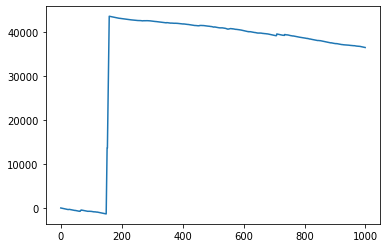

In [99]:
plt.plot(np.cumsum(payouts))

In [125]:
def get_random_lineups(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9, num_lineups=10):
    players = list(set(projections.keys()).intersection(list(results.Player)))
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')

    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(projections[name]['ceil']/2-projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    opt_values = [np.random.randint(1000) for name in players]
    LINEUPS = []
    for i in range(num_lineups):
        #optimizing function
        prob += pulp.lpDot([choices[v] for v in players],opt_values), "Total Projection"
        prob.solve()
        prob += lpSum([choices[v] for v in players if choices[v].varValue == 1]) <=3
        #for v in prob.variables():
        #    print(v.name, "=", v.varValue)
        print("actual", (pulp.lpDot([choices[v].varValue for v in players],
                        [get_Fpts(results, name) for name in players])))
        print("results", pulp.lpDot([choices[v].varValue for v in players],[projections[name]['points'] for name in players]))
        print([choices[v] for v in players if choices[v].varValue == 1])
        for i in range(len(opt_values)):
            if choices[players[i]].varValue ==1:
                opt_values[i] /=2
        #print(opt_values)
        print("Status:", LpStatus[prob.status])#print(prob.status)
        if LpStatus[prob.status] == "Infeasible":
            break
        print(value(prob.objective))
        # The problem data is written to an .lp file
        #prob.writeLP("letsee.lp")
        #return(value(prob.objective))
        #return prob
        LINEUPS.append([player for player in players if (choices[player].varValue == 1)])
    #return(pulp.lpDot([choices[v].varValue for v in players],
    #                    [get_Fpts(results, name) for name in players])).value()
    return LINEUPS

In [126]:
get_random_lineups(data["2019-02-02"]["ACTUAL_POINTS"], data["2019-02-02"]["PROJECTIONS"], optimal_expected_ratio=.75, optimal_variance_ratio=.75)

actual 239.5
results 265.61
[Choice_Malik_Beasley, Choice_Terrence_Ross, Choice_Torrey_Craig, Choice_KarlAnthony_Towns, Choice_John_Collins, Choice_Rudy_Gobert, Choice_Derrick_White, Choice_Rondae_HollisJefferson]
Status: Optimal
7465.0
actual 266.75
results 260.35
[Choice_Jarrett_Allen, Choice_Joel_Embiid, Choice_Shaquille_Harrison, Choice_Bobby_Portis, Choice_Larry_Nance, Choice_DeMar_DeRozan, Choice_Derrick_Favors, Choice_Kelly_Oubre]
Status: Optimal
6468.0
actual 215.5
results 249.9
[Choice_Dwight_Powell, Choice_Bogdan_Bogdanovic, Choice_Kemba_Walker, Choice_Derrick_Rose, Choice_Shaun_Livingston, Choice_Myles_Turner, Choice_Justise_Winslow, Choice_Nikola_Vucevic]
Status: Optimal
6024.0
actual 262.75
results 270.64
[Choice_Stephen_Curry, Choice_Jahlil_Okafor, Choice_Dwyane_Wade, Choice_Michael_KiddGilchrist, Choice_Bobby_Portis, Choice_Malik_Monk, Choice_Kevin_Durant, Choice_Klay_Thompson]
Status: Optimal
5427.5
actual 280.25
results 262.33000000000004
[Choice_Malik_Beasley, Choice_

[['Malik Beasley',
  'Terrence Ross',
  'Torrey Craig',
  'KarlAnthony Towns',
  'John Collins',
  'Rudy Gobert',
  'Derrick White',
  'Rondae HollisJefferson'],
 ['Jarrett Allen',
  'Joel Embiid',
  'Shaquille Harrison',
  'Bobby Portis',
  'Larry Nance',
  'DeMar DeRozan',
  'Derrick Favors',
  'Kelly Oubre'],
 ['Dwight Powell',
  'Bogdan Bogdanovic',
  'Kemba Walker',
  'Derrick Rose',
  'Shaun Livingston',
  'Myles Turner',
  'Justise Winslow',
  'Nikola Vucevic'],
 ['Stephen Curry',
  'Jahlil Okafor',
  'Dwyane Wade',
  'Michael KiddGilchrist',
  'Bobby Portis',
  'Malik Monk',
  'Kevin Durant',
  'Klay Thompson'],
 ['Malik Beasley',
  'KarlAnthony Towns',
  'Jeremy Lin',
  'Kemba Walker',
  'Bobby Portis',
  'Devin Harris',
  'Zach LaVine',
  'Josh Richardson'],
 ['Taurean Prince',
  'Kenneth Faried',
  'Willie CauleyStein',
  'Kemba Walker',
  'Corey Brewer',
  'Bobby Portis',
  'Nikola Vucevic',
  'Brook Lopez'],
 ['Jordan McRae',
  'Stephen Curry',
  'Terrence Ross',
  'Monte 

In [154]:
vals = []
payouts = []
for date in list(data.keys())[-100:]:
    projs = data[date]["PROJECTIONS"]
    #print(data[date].keys())
    results = data[date]["ACTUAL_POINTS"]
    contest = data[date]["CONTESTS"][0]
    lineups = get_random_lineups(data[date]["ACTUAL_POINTS"], data[date]["PROJECTIONS"], optimal_expected_ratio=.9, optimal_variance_ratio=.85, num_lineups=3)
    for lineup in lineups:
        sample = set(lineup)
        #sample = random.sample(candidates, 8)
        predicted_points = sum([projs[p]["points"]-np.mean(player_data[p]["mean"]) for p in sample])
        predicted_variance = (sum([player_data[p]["std"]**2 for p in sample]))**.5
        actual_points = sum([get_Fpts(results,p) for p in sample])
        resid = (actual_points-predicted_points)/predicted_variance
        vals.append(resid)
        payout = get_payout(contest["PAYOUTS"], actual_points) - float(contest["Buy In"][1:])
        payouts.append(payout)
        print(date, len(candidates), predicted_points, predicted_variance, actual_points, resid)

actual 252.5
results 279.87
[Choice_Jabari_Parker, Choice_Devin_Booker, Choice_Tomas_Satoransky, Choice_Jamal_Murray, Choice_Kemba_Walker, Choice_Blake_Griffin, Choice_DeAndre_Bembry, Choice_Thomas_Bryant]
Status: Optimal
5659.0
actual 253.0
results 280.37
[Choice_Jabari_Parker, Choice_Troy_Brown, Choice_Stephen_Curry, Choice_Buddy_Hield, Choice_Kemba_Walker, Choice_Bobby_Portis, Choice_Domantas_Sabonis, Choice_Thomas_Bryant]
Status: Optimal
4244.0
actual 199.75
results 279.45
[Choice_Jabari_Parker, Choice_KarlAnthony_Towns, Choice_Kemba_Walker, Choice_Domantas_Sabonis, Choice_Josh_Jackson, Choice_Rudy_Gobert, Choice_Tony_Parker, Choice_Trey_Burke]
Status: Optimal
3548.25
2019-03-21 119 280.5764974533799 32.79862950615002 252.5 -0.8560265436735796
2019-03-21 119 282.2928738254794 31.52292640468707 253.0 -0.9292561689679892
2019-03-21 119 277.2722656811292 32.00002246848645 199.75 -2.4225691015521313
actual 257.0
results 270.43
[Choice_Jonas_Valanciunas, Choice_Mario_Hezonja, Choice_Rud

actual 296.75
results 273.17
[Choice_Jonas_Valanciunas, Choice_Timothe_LuwawuCabarrot, Choice_Devin_Booker, Choice_James_Johnson, Choice_Tyus_Jones, Choice_Anthony_Tolliver, Choice_Myles_Turner, Choice_Nikola_Vucevic]
Status: Optimal
7347.0
actual 319.75
results 271.92
[Choice_Fred_VanVleet, Choice_Jonas_Valanciunas, Choice_Bruno_Caboclo, Choice_KarlAnthony_Towns, Choice_Hassan_Whiteside, Choice_Dion_Waiters, Choice_Josh_Jackson, Choice_Myles_Turner]
Status: Optimal
5569.5
actual 328.25
results 271.11
[Choice_Jonas_Valanciunas, Choice_Timothe_LuwawuCabarrot, Choice_Devin_Booker, Choice_Bam_Adebayo, Choice_Jonathan_Isaac, Choice_Marc_Gasol, Choice_Zach_Collins, Choice_Mike_Conley]
Status: Optimal
4616.0
2019-03-30 119 270.871625612445 29.13902586452269 296.75 0.8881001893430636
2019-03-30 119 267.9974283174001 31.67299635866703 319.75 1.633965132207591
2019-03-30 119 270.35362406303756 28.933261330997826 328.25 2.001031797785437
actual 222.25
results 271.65
[Choice_Jonas_Valanciunas, Ch

actual 305.25
results 273.44
[Choice_DJ_Wilson, Choice_Lou_Williams, Choice_DeAaron_Fox, Choice_John_Collins, Choice_DeMar_DeRozan, Choice_Trey_Burke, Choice_Montrezl_Harrell, Choice_Boban_Marjanovic]
Status: Optimal
6704.0
actual 264.5
results 270.27000000000004
[Choice_Jerami_Grant, Choice_Lou_Williams, Choice_Kemba_Walker, Choice_Mitchell_Robinson, Choice_Doug_McDermott, Choice_Hassan_Whiteside, Choice_John_Collins, Choice_Georges_Niang]
Status: Optimal
4792.5
actual 299.75
results 270.14
[Choice_Taurean_Prince, Choice_Kemba_Walker, Choice_John_Collins, Choice_Georges_Niang, Choice_DeMar_DeRozan, Choice_Danilo_Gallinari, Choice_Seth_Curry, Choice_Boban_Marjanovic]
Status: Optimal
3963.0
2019-04-10 119 269.65853797279397 29.838002249986594 305.25 1.1928232235193301
2019-04-10 119 269.5453649300065 28.459999845711412 264.5 -0.17727916224028942
2019-04-10 119 266.58358460852645 28.109685320981853 299.75 1.1798928025251572
actual 290.0
results 266.11
[Choice_Fred_VanVleet, Choice_Montre

actual 217.25
results 285.49
[Choice_Stephen_Curry, Choice_Terrence_Ross, Choice_Ben_Simmons, Choice_Bogdan_Bogdanovic, Choice_DeAaron_Fox, Choice_Nerlens_Noel, Choice_Montrezl_Harrell, Choice_Kelly_Oubre]
Status: Optimal
6761.0
actual 241.5
results 276.93
[Choice_Christian_Wood, Choice_Lauri_Markkanen, Choice_Eric_Bledsoe, Choice_Ben_Simmons, Choice_James_Harden, Choice_Royce_ONeale, Choice_Nerlens_Noel, Choice_Montrezl_Harrell]
Status: Optimal
5317.0
actual 281.0
results 277.01
[Choice_Frank_Kaminsky, Choice_Jarrett_Allen, Choice_Serge_Ibaka, Choice_Ben_Simmons, Choice_James_Harden, Choice_Bogdan_Bogdanovic, Choice_Buddy_Hield, Choice_Richaun_Holmes]
Status: Optimal
4530.0
2019-10-30 119 284.9806769737182 28.686053651066416 217.25 -2.361101244443927
2019-10-30 119 281.24410812970797 31.579902563675223 241.5 -1.258525356421575
2019-10-30 119 278.7638020801673 30.14109394475032 281.0 0.0741910006296299
actual 233.5
results 254.67
[Choice_Brandon_Ingram, Choice_Bam_Adebayo, Choice_DeMar

actual 254.75
results 270.98
[Choice_Ben_Simmons, Choice_Bruno_Caboclo, Choice_James_Harden, Choice_Kevin_Love, Choice_Jordan_Clarkson, Choice_James_Ennis, Choice_Rudy_Gobert, Choice_Joe_Ingles]
Status: Optimal
7151.0
actual 275.0
results 272.54
[Choice_Bojan_Bogdanovic, Choice_PJ_Tucker, Choice_Ben_Simmons, Choice_James_Harden, Choice_Cameron_Johnson, Choice_Doug_McDermott, Choice_Royce_ONeale, Choice_Domantas_Sabonis]
Status: Optimal
5590.5
actual 264.75
results 272.81000000000006
[Choice_TJ_McConnell, Choice_Frank_Kaminsky, Choice_RJ_Barrett, Choice_James_Harden, Choice_Jaren_Jackson, Choice_Domantas_Sabonis, Choice_Georges_Niang, Choice_Rudy_Gobert]
Status: Optimal
4872.0
2019-12-07 119 267.35936641963804 30.287280366647725 254.75 -0.41632547614025583
2019-12-07 119 272.8949817582269 26.848178049907272 275.0 0.07840450990231643
2019-12-07 119 266.3976789462348 28.991532975365228 264.75 -0.056833108743676156
actual 252.5
results 256.46999999999997
[Choice_Mario_Hezonja, Choice_Paul_

actual 268.5
results 296.38
[Choice_Christian_Wood, Choice_Jimmy_Butler, Choice_Thon_Maker, Choice_Kyle_Lowry, Choice_Kristaps_Porzingis, Choice_Brook_Lopez, Choice_Markieff_Morris, Choice_Pascal_Siakam]
Status: Optimal
6635.0
actual 294.75
results 292.4
[Choice_Christian_Wood, Choice_Bam_Adebayo, Choice_Thon_Maker, Choice_Derrick_Rose, Choice_Hassan_Whiteside, Choice_Giannis_Antetokounmpo, Choice_Ben_McLemore, Choice_Derrick_Jones]
Status: Optimal
5352.5
actual 274.0
results 290.68000000000006
[Choice_Dwight_Powell, Choice_Damian_Lillard, Choice_James_Harden, Choice_Thon_Maker, Choice_Derrick_Rose, Choice_Tristan_Thompson, Choice_Carmelo_Anthony, Choice_Markieff_Morris]
Status: Optimal
4449.5
2019-12-16 119 296.31324887011334 30.798796683188588 268.5 -0.9030628422341936
2019-12-16 119 296.2179048859253 30.45800190831641 294.75 -0.04819439207942556
2019-12-16 119 290.6018207233982 29.12224869177389 274.0 -0.5700734479369952
actual 267.5
results 268.13
[Choice_Taurean_Prince, Choice_Jev

actual 250.75
results 259.42
[Choice_Andre_Drummond, Choice_Jonas_Valanciunas, Choice_Rudy_Gay, Choice_DeAndre_Jordan, Choice_Gorgui_Dieng, Choice_Shabazz_Napier, Choice_Luka_Doncic, Choice_Nerlens_Noel]
Status: Optimal
7122.0
actual 204.5
results 255.48000000000005
[Choice_Andre_Drummond, Choice_Taurean_Prince, Choice_Gorgui_Dieng, Choice_Brandon_Clarke, Choice_Hassan_Whiteside, Choice_Bryn_Forbes, Choice_Kristaps_Porzingis, Choice_Svi_Mykhailiuk]
Status: Optimal
6030.0
actual 206.0
results 255.55999999999997
[Choice_Andre_Drummond, Choice_Jarrett_Allen, Choice_Timothe_LuwawuCabarrot, Choice_Tony_Snell, Choice_Gorgui_Dieng, Choice_Kent_Bazemore, Choice_Nemanja_Bjelica, Choice_Luka_Doncic]
Status: Optimal
4910.5
2019-12-26 119 261.2659731527659 31.33835222165452 250.75 -0.3355624149727783
2019-12-26 119 252.90457347429637 29.511728369655955 204.5 -1.6401809093657183
2019-12-26 119 254.77599761136193 29.177873038674658 206.0 -1.671677628684941
actual 223.25
results 272.51
[Choice_Draymo

actual 274.25
results 265.58000000000004
[Choice_Andre_Drummond, Choice_Christian_Wood, Choice_Dennis_Schroder, Choice_LaMarcus_Aldridge, Choice_Michael_Porter, Choice_Alex_Len, Choice_Gordon_Hayward, Choice_Ish_Smith]
Status: Optimal
6584.0
actual 253.25
results 264.09
[Choice_Andre_Drummond, Choice_Alfonzo_McKinnie, Choice_Buddy_Hield, Choice_Michael_Porter, Choice_Brandon_Ingram, Choice_Patty_Mills, Choice_Zach_LaVine, Choice_Joe_Ingles]
Status: Optimal
4896.0
actual 250.75
results 267.16
[Choice_Andre_Drummond, Choice_Shai_GilgeousAlexander, Choice_Michael_Porter, Choice_Alex_Len, Choice_Royce_ONeale, Choice_Trae_Young, Choice_Cody_Zeller, Choice_Joe_Ingles]
Status: Optimal
4167.0
2020-01-04 119 267.1416168013744 32.82251592921402 274.25 0.21657033281530635
2020-01-04 119 267.78021906585343 29.194275165132925 253.25 -0.49770782058007884
2020-01-04 119 269.44890249190985 30.994449849707536 250.75 -0.603298415767373
actual 317.5
results 282.78000000000003
[Choice_Christian_Wood, Choi

actual 236.0
results 265.08
[Choice_Austin_Rivers, Choice_Kyle_Anderson, Choice_Kawhi_Leonard, Choice_Brandon_Clarke, Choice_Alec_Burks, Choice_Tim_Hardaway, Choice_Giannis_Antetokounmpo, Choice_Omari_Spellman]
Status: Optimal
6678.0
actual 224.5
results 263.96
[Choice_Donovan_Mitchell, Choice_Eric_Bledsoe, Choice_Kyle_Anderson, Choice_Dario_Saric, Choice_Lou_Williams, Choice_Jaren_Jackson, Choice_Trae_Young, Choice_DeAnthony_Melton]
Status: Optimal
5209.5
actual 278.0
results 264.39
[Choice_Julius_Randle, Choice_Darius_Garland, Choice_Devin_Booker, Choice_Dorian_FinneySmith, Choice_Larry_Nance, Choice_Collin_Sexton, Choice_Trae_Young, Choice_Donte_DiVincenzo]
Status: Optimal
4731.5
2020-01-14 119 260.8361830981417 28.5300835154349 236.0 -0.8705261267358443
2020-01-14 119 258.3080372128433 30.70366005739763 224.5 -1.101107722976425
2020-01-14 119 269.65879994613897 29.427343423959343 278.0 0.283450664699476
actual 263.5
results 281.2
[Choice_Jaylen_Brown, Choice_Damian_Lillard, Choice_

actual 248.5
results 275.17
[Choice_KarlAnthony_Towns, Choice_Kemba_Walker, Choice_Jaren_Jackson, Choice_Nerlens_Noel, Choice_Tyler_Herro, Choice_Tim_Frazier, Choice_Markieff_Morris, Choice_Will_Barton]
Status: Optimal
6848.0
actual 304.5
results 275.51
[Choice_Julius_Randle, Choice_DAngelo_Russell, Choice_Patty_Mills, Choice_Mike_Muscala, Choice_Russell_Westbrook, Choice_Nerlens_Noel, Choice_Gordon_Hayward, Choice_Tyler_Herro]
Status: Optimal
5205.0
actual 210.5
results 281.07
[Choice_Damion_Lee, Choice_Fred_VanVleet, Choice_Christian_Wood, Choice_James_Harden, Choice_Bogdan_Bogdanovic, Choice_Derrick_Rose, Choice_Langston_Galloway, Choice_Tyler_Herro]
Status: Optimal
4607.25
2020-01-24 119 268.07292580833746 30.90004244039993 248.5 -0.6334271496904822
2020-01-24 119 273.04853879356796 29.080335391641764 304.5 1.08153708624254
2020-01-24 119 285.051704278516 31.364269678146673 210.5 -2.376962863906905
actual 208.5
results 262.12
[Choice_Steven_Adams, Choice_Shai_GilgeousAlexander, Cho

actual 288.75
results 268.44
[Choice_Chris_Boucher, Choice_Devin_Booker, Choice_Terence_Davis, Choice_Danuel_House, Choice_James_Harden, Choice_Zach_LaVine, Choice_Jrue_Holiday, Choice_Tyler_Johnson]
Status: Optimal
6168.0
actual 275.0
results 268.62
[Choice_Deandre_Ayton, Choice_Devin_Booker, Choice_Eric_Gordon, Choice_Mikal_Bridges, Choice_James_Harden, Choice_Kelly_Oubre, Choice_Elie_Okobo, Choice_Cheick_Diallo]
Status: Optimal
4852.0
actual 271.0
results 269.87
[Choice_Chris_Boucher, Choice_Fred_VanVleet, Choice_Devin_Booker, Choice_Ben_McLemore, Choice_Robin_Lopez, Choice_James_Harden, Choice_Russell_Westbrook, Choice_Elie_Okobo]
Status: Optimal
3653.0
2020-02-02 119 273.24644910002263 31.126268757861784 288.75 0.498085749390104
2020-02-02 119 267.0231127431236 30.013000964198834 275.0 0.26578106156034453
2020-02-02 119 270.65724299631165 29.885234565699776 271.0 0.011469108697635623
actual 279.0
results 277.14
[Choice_Jeff_Teague, Choice_Harrison_Barnes, Choice_Bradley_Beal, Choi

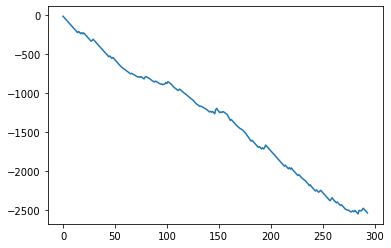

In [155]:
plt.plot(np.cumsum(payouts))

(array([ 2.,  7., 17., 47., 57., 59., 41., 38., 19.,  7.]),
 array([-3.15624805, -2.61194523, -2.06764241, -1.52333959, -0.97903677,
        -0.43473395,  0.10956887,  0.65387169,  1.19817451,  1.74247733,
         2.28678015]),
 <a list of 10 Patch objects>)

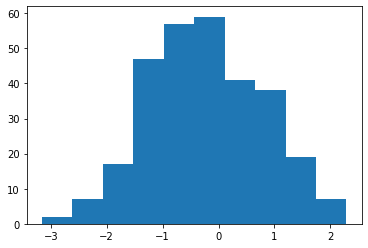

In [156]:
plt.hist(vals)

In [157]:
np.std(vals)

1.01341922168534

In [158]:
stats.skew(vals)

0.028681454686355877

In [159]:
np.mean(vals)

-0.22378569747928773

In [12]:
data['2017-11-01']['ACTUAL_POINTS']

Player Pos     Avg   Fpts  \
0             John Wall  PG  37.44%  42.75   
1           Jason Smith  PF  34.55%  10.00   
2           Joel Embiid   C  26.33%  58.00   
3      Domantas Sabonis  PF  26.22%  41.00   
4          LeBron James  SF  24.90%  61.00   
..                  ...  ..     ...    ...   
395          Tyus Jones  PG   0.00%  11.75   
396        Cole Aldrich   C   0.00%    NaN   
397       Justin Patton   C   0.00%    NaN   
398        Aaron Brooks  PG   0.00%    NaN   
399  Marcus GeorgesHunt  SG   0.00%    NaN   

    NBA $525K Wednesday Starting 5 Special NBA $60K Excellent 8_s  \
0                          25.16% (-12.28)         34.30% (-3.14)   
1                          17.71% (-16.84)         29.20% (-5.35)   
2                           17.33% (-9.00)         20.48% (-5.85)   
3                            29.76% (3.54)         21.29% (-4.93)   
4                           20.97% (-3.93)          25.41% (0.51)   
..                                     ...                    ...   
395                           0.00% (0.00)           0.00% (0.00)   
396                           0.00% (0.00)           0.00% (0.00)   
397                           0.00% (0.00)           0.00% (0.00)   
398                           0.00% (0.00)           0.00% (0.00)   
399                           0.00% (0.00)           0.00% (0.00)   

    NBA $250K Triple Threat [$25K to 1st] NBA $75K Fall Festival 3 Max Encore  \
0                          35.00% (-2.44)                      31.89% (-5.55)   
1                          28.23% (-6.32)                      28.47% (-6.08)   
2                          21.33% (-5.00)                      26.13% (-0.20)   
3                          21.69% (-4.53)                       33.33% (7.11)   
4                           26.81% (1.91)                      23.96% (-0.94)   
..                                    ...                                 ...   
395                          0.00% (0.00)                        0.00% (0.00)   
396                          0.00% (0.00)                        0.00% (0.00)   
397                          0.00% (0.00)                        0.00% (0.00)   
398                          0.00% (0.00)                        0.00% (0.00)   
399                          0.00% (0.00)                        0.00% (0.00)   

    NBA $600K MEGA Alley Oop [$100K to 1st] NBA GIANT $25 Double Up  
0                             38.63% (1.19)          59.66% (22.22)  
1                             34.72% (0.17)          68.97% (34.42)  
2                            25.23% (-1.10)          47.48% (21.15)  
3                            19.32% (-6.90)           31.94% (5.72)  
4                             29.31% (4.41)          22.93% (-1.97)  
..                                      ...                     ...  
395                            0.00% (0.00)            0.00% (0.00)  
396                            0.00% (0.00)            0.00% (0.00)  
397                            0.00% (0.00)            0.00% (0.00)  
398                            0.00% (0.00)            0.00% (0.00)  
399                            0.00% (0.00)            0.00% (0.00)  

[400 rows x 10 columns]

# Can we improve player predictions

In [87]:
#returns predicted/actual pair
get_pairs("LeBron James")[68:]

[(51.51, 18.7, 65.68, 43.75),
 (54.4, 23.5, 77.9, 67.0),
 (58.62, 25.91, 88.52, 50.75),
 (54.71, 25.06, 78.89, 68.25),
 (53.41, 19.28, 81.24, 59.25),
 (52.85, 19.18, 77.85, 62.0),
 (53.96, 18.4, 77.54, 49.75),
 (53.89, 23.44, 79.81, 47.75),
 (52.31, 21.13, 75.17, 31.0),
 (53.83, 18.63, 76.76, 55.5),
 (53.62, 21.29, 80.54, 38.75),
 (54.69, 22.97, 77.88, 44.25),
 (55.77, 23.42, 79.42, 80.0),
 (52.63, 20.89, 79.1, 39.5),
 (53.03, 21.05, 79.65, 73.5),
 (52.63, 20.89, 79.1, 62.5),
 (52.99, 22.26, 75.46, 51.0),
 (50.74, 20.04, 76.62, 31.75),
 (51.07, 21.4, 61.9, 62.75),
 (53.51, 22.47, 64.75, 41.25),
 (51.7, 21.71, 62.56, 61.75),
 (51.88, 20.6, 66.25, 68.0),
 (50.37, 20.0, 64.37, 45.0),
 (54.31, 22.81, 65.72, 61.75),
 (53.56, 21.26, 68.45, 45.25),
 (53.23, 21.13, 67.97, 61.5),
 (53.64, 21.3, 68.5, 25.0),
 (53.38, 21.19, 68.22, 68.25),
 (52.45, 22.03, 63.46, 54.5),
 (50.97, 20.24, 65.09, 43.25),
 (50.75, 50.75, 50.75, 57.0),
 (49.76, 28.46, 75.29, 40.25),
 (47.75, 27.31, 72.25, 72.5),
 (54.24

r value is (0.650081107060829, 1.6885735174382662e-19)


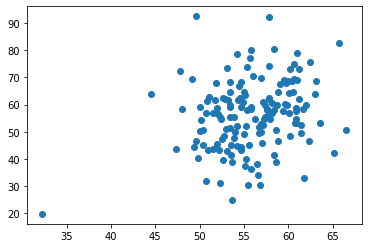

In [470]:
#case study LeBron James
case = get_pairs("LeBron James")#[68:]
plt.scatter(np.array(case)[:,0], np.array(case)[:,3])
print("r value is {}".format(stats.pearsonr(np.array(case)[:,0], np.array(case)[:,1])))

In [471]:
est = sm.OLS(np.array(case)[:,3], sm.add_constant(np.array(case)[:,0])).fit()
est.rsquared

0.0702729379634679

In [161]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     11.23
Date:                Sun, 08 Mar 2020   Prob (F-statistic):            0.00108
Time:                        12:30:27   Log-Likelihood:                -457.35
No. Observations:                 120   AIC:                             918.7
Df Residuals:                     118   BIC:                             924.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3646      7.883      0.807      0.421      -9.245      21.974
x1             0.8161      0.244      3.351      0.001       0.334       1.298
==============================================================================
Omnibus:                        0.207   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.229
Skew:                           0.096   Prob(JB):                        0.892
Kurtosis:                       2.905   Cond. No.                         254.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [478]:
#lets try exponential smoothing
usual_deviation = 0
#get_pairs("LeBron James")
vals = np.array(get_pairs("LeBron James"))
exp_projs = []
for elt in vals:
    projection = usual_deviation + elt[0]
    exp_projs.append(projection)
    deviation = elt[3] - projection
    usual_deviation = usual_deviation+deviation*.1

In [479]:
est = sm.OLS(np.array(vals)[:,3], sm.add_constant(np.array(exp_projs))).fit()
est.rsquared

0.04471850730222826

In [84]:
len(np.array(vals)[:,3])

165

In [83]:
len((exp_projs))

165

In [93]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

In [165]:
x = get_residuals("LeBron James")

In [228]:
def one_sided_kurtosis(dist):
    m = dist.mean()
    dev = dist.std()
    dist = [elt for elt in dist if elt>m]
    return sum(((dist-m)/dev)**4)/len(dist) - 3

In [229]:
for player in PLAYERS:
    x = np.array(get_residuals(player))
    if len(x) > 20:
        print( '{} excess kurtosis of normal distribution (should be 0): {}'.format(player,  one_sided_kurtosis(x) ))
        print( '{} skewness of normal distribution (should be 0): {}'.format(player, skew(x) ))
from scipy.stats import kurtosis, skew


Paul George excess kurtosis of normal distribution (should be 0): -0.38391366499444013
Paul George skewness of normal distribution (should be 0): -0.26466375692436267
Will Barton excess kurtosis of normal distribution (should be 0): -0.6895878552131505
Will Barton skewness of normal distribution (should be 0): -0.14410995573066157
DJ Augustin excess kurtosis of normal distribution (should be 0): -0.9831940067756202
DJ Augustin skewness of normal distribution (should be 0): -0.2086706800825388
Kendrick Nunn excess kurtosis of normal distribution (should be 0): -1.728301658564599
Kendrick Nunn skewness of normal distribution (should be 0): -0.5819172465928525
Trevor Ariza excess kurtosis of normal distribution (should be 0): -0.822434186658437
Trevor Ariza skewness of normal distribution (should be 0): -0.23276118013843286
Isaiah Hartenstein excess kurtosis of normal distribution (should be 0): -1.7549876051459203
Isaiah Hartenstein skewness of normal distribution (should be 0): -0.91524

Jerami Grant excess kurtosis of normal distribution (should be 0): -1.132858485759436
Jerami Grant skewness of normal distribution (should be 0): -0.4165030305739155
Glenn Robinson excess kurtosis of normal distribution (should be 0): -1.3371086332864281
Glenn Robinson skewness of normal distribution (should be 0): -0.19583971851749712
Cedi Osman excess kurtosis of normal distribution (should be 0): 0.5349881542551969
Cedi Osman skewness of normal distribution (should be 0): -0.028802049783817667
Abdel Nader excess kurtosis of normal distribution (should be 0): -1.6083830904658833
Abdel Nader skewness of normal distribution (should be 0): -0.5742400164722224
Harrison Barnes excess kurtosis of normal distribution (should be 0): -0.8415933753041376
Harrison Barnes skewness of normal distribution (should be 0): -0.12606486324038552
Ersan Ilyasova excess kurtosis of normal distribution (should be 0): -1.3928346409334849
Ersan Ilyasova skewness of normal distribution (should be 0): -0.30051

Giannis Antetokounmpo excess kurtosis of normal distribution (should be 0): 0.24705329422789024
Giannis Antetokounmpo skewness of normal distribution (should be 0): -0.025452980044831562
DeAndre Hunter excess kurtosis of normal distribution (should be 0): -1.3086387668255492
DeAndre Hunter skewness of normal distribution (should be 0): -0.22419272924875241
Jarell Martin excess kurtosis of normal distribution (should be 0): -0.04926867054657569
Jarell Martin skewness of normal distribution (should be 0): -0.14142544269267548
Mason Plumlee excess kurtosis of normal distribution (should be 0): -1.0643214237705236
Mason Plumlee skewness of normal distribution (should be 0): -0.36307379168948123
Jarrett Jack excess kurtosis of normal distribution (should be 0): -1.808176095425458
Jarrett Jack skewness of normal distribution (should be 0): -0.6988507135064005
Zach Collins excess kurtosis of normal distribution (should be 0): -1.6210147406975324
Zach Collins skewness of normal distribution (s

Malcolm Brogdon excess kurtosis of normal distribution (should be 0): 2.1940399272040194
Malcolm Brogdon skewness of normal distribution (should be 0): 0.3616342458920259
Spencer Dinwiddie excess kurtosis of normal distribution (should be 0): -0.4854877139617
Spencer Dinwiddie skewness of normal distribution (should be 0): -0.28162805100175
AlFarouq Aminu excess kurtosis of normal distribution (should be 0): -0.5683532647937817
AlFarouq Aminu skewness of normal distribution (should be 0): -0.14223501299310295
John Henson excess kurtosis of normal distribution (should be 0): 0.3907711916681076
John Henson skewness of normal distribution (should be 0): -0.0034886411622380613
DeAnthony Melton excess kurtosis of normal distribution (should be 0): -1.1771340312151775
DeAnthony Melton skewness of normal distribution (should be 0): -0.2008013821922103
Terrence Ross excess kurtosis of normal distribution (should be 0): -0.46837729842395115
Terrence Ross skewness of normal distribution (should 

James Harden skewness of normal distribution (should be 0): -0.36269187861846885
Jawun Evans excess kurtosis of normal distribution (should be 0): -1.4364705556992314
Jawun Evans skewness of normal distribution (should be 0): -0.5099957622305646
Terrance Ferguson excess kurtosis of normal distribution (should be 0): -1.8276487181646104
Terrance Ferguson skewness of normal distribution (should be 0): -1.151264300485532
Jamal Murray excess kurtosis of normal distribution (should be 0): -0.6274505012218858
Jamal Murray skewness of normal distribution (should be 0): -0.10495117714763653
Omari Spellman excess kurtosis of normal distribution (should be 0): -1.7796058855129278
Omari Spellman skewness of normal distribution (should be 0): -0.8729376654498718
Nikola Jokic excess kurtosis of normal distribution (should be 0): -0.92344239261238
Nikola Jokic skewness of normal distribution (should be 0): -0.2701024898635037
Guillermo Hernangomez excess kurtosis of normal distribution (should be 0)

Milos Teodosic excess kurtosis of normal distribution (should be 0): -0.3202802081947369
Milos Teodosic skewness of normal distribution (should be 0): 0.008248935002655763
Jon Leuer excess kurtosis of normal distribution (should be 0): -0.21915844639384918
Jon Leuer skewness of normal distribution (should be 0): -0.05680069496363275
Nicolo Melli excess kurtosis of normal distribution (should be 0): -0.46735555025449704
Nicolo Melli skewness of normal distribution (should be 0): 0.21391518661354322
Marcus GeorgesHunt excess kurtosis of normal distribution (should be 0): 8.052007585011683
Marcus GeorgesHunt skewness of normal distribution (should be 0): 1.0753914037274346
Duncan Robinson excess kurtosis of normal distribution (should be 0): -2.0341577859669355
Duncan Robinson skewness of normal distribution (should be 0): -0.758474724475401
Brook Lopez excess kurtosis of normal distribution (should be 0): -0.8928775512322953
Brook Lopez skewness of normal distribution (should be 0): -0.2

Trey Burke excess kurtosis of normal distribution (should be 0): -2.129190080177677
Trey Burke skewness of normal distribution (should be 0): -1.1396694170012445
Nassir Little excess kurtosis of normal distribution (should be 0): -1.5199087018073505
Nassir Little skewness of normal distribution (should be 0): -0.2780816953068959
Justin Jackson excess kurtosis of normal distribution (should be 0): -1.1704298460797695
Justin Jackson skewness of normal distribution (should be 0): -0.3797611667848329
Eric Paschall excess kurtosis of normal distribution (should be 0): -0.5866505547569223
Eric Paschall skewness of normal distribution (should be 0): 0.1012130693291543
OG Anunoby excess kurtosis of normal distribution (should be 0): -0.834402607498625
OG Anunoby skewness of normal distribution (should be 0): -0.43633016527346485
Jason Terry excess kurtosis of normal distribution (should be 0): -1.0774827622941923
Jason Terry skewness of normal distribution (should be 0): -0.3228104156764788
Wa

Luka Doncic excess kurtosis of normal distribution (should be 0): 5.429132925113503
Luka Doncic skewness of normal distribution (should be 0): 0.7268741028477911
Brad Wanamaker excess kurtosis of normal distribution (should be 0): -1.8260473359070366
Brad Wanamaker skewness of normal distribution (should be 0): -0.6566607257566468
TJ Warren excess kurtosis of normal distribution (should be 0): 0.16604078245696252
TJ Warren skewness of normal distribution (should be 0): 0.03850037446498519
Russell Westbrook excess kurtosis of normal distribution (should be 0): -0.2269669152580538
Russell Westbrook skewness of normal distribution (should be 0): 0.09254089827943116
Reggie Bullock excess kurtosis of normal distribution (should be 0): 1.0271582761486266
Reggie Bullock skewness of normal distribution (should be 0): 0.19048066695315308
Kyrie Irving excess kurtosis of normal distribution (should be 0): 1.4362380896960056
Kyrie Irving skewness of normal distribution (should be 0): 0.26011982501

Aaron Gordon excess kurtosis of normal distribution (should be 0): -0.9412895706760729
Aaron Gordon skewness of normal distribution (should be 0): -0.5091062139616872
Thaddeus Young excess kurtosis of normal distribution (should be 0): -0.24798804836660482
Thaddeus Young skewness of normal distribution (should be 0): -0.3604969912178721
Shelvin Mack excess kurtosis of normal distribution (should be 0): -1.510412754069716
Shelvin Mack skewness of normal distribution (should be 0): -0.4970838332600412
Jarrett Allen excess kurtosis of normal distribution (should be 0): -0.8584595944267348
Jarrett Allen skewness of normal distribution (should be 0): -0.3024431012496372
Brandon Paul excess kurtosis of normal distribution (should be 0): -2.3197095740933404
Brandon Paul skewness of normal distribution (should be 0): -1.127447451235552
Mike James excess kurtosis of normal distribution (should be 0): 1.2067874474097247
Mike James skewness of normal distribution (should be 0): -0.189784952777782

Lonzo Ball excess kurtosis of normal distribution (should be 0): -0.4075106609398973
Lonzo Ball skewness of normal distribution (should be 0): -0.086197291532193
Richaun Holmes excess kurtosis of normal distribution (should be 0): -1.1295548239222402
Richaun Holmes skewness of normal distribution (should be 0): -0.42578409085322083
Jason Smith excess kurtosis of normal distribution (should be 0): -0.6598221532586948
Jason Smith skewness of normal distribution (should be 0): 0.029861719815319553
Cameron Payne excess kurtosis of normal distribution (should be 0): 0.22802959119011623
Cameron Payne skewness of normal distribution (should be 0): 0.08569300788232591
Thomas Bryant excess kurtosis of normal distribution (should be 0): -1.9196023581513888
Thomas Bryant skewness of normal distribution (should be 0): -0.9303779844944731
Joe Harris excess kurtosis of normal distribution (should be 0): -0.7277402786697276
Joe Harris skewness of normal distribution (should be 0): -0.1660517862166822

Emmanuel Mudiay excess kurtosis of normal distribution (should be 0): -1.0782108704164086
Emmanuel Mudiay skewness of normal distribution (should be 0): -0.1936633206804228


In [316]:
def one_sided_prupes(dist, val):
    m = dist.mean()
    dev = dist.std()
    dist = [elt for elt in dist if elt>m]
    return sum(((dist-m)/dev)**val)/len(dist) - 3

In [317]:
def generate_prupes_dict(val):
    output = {}
    for player in PLAYERS:
        x = np.array(get_residuals(player))
        if len(x) > 25:
            output[player]= one_sided_prupes(x[-5:], val)
        else:
            output[player] = 0
    return output

In [318]:
PLAYERS_KURTOSIS = generate_prupes_dict(4)

In [319]:
PLAYERS_PRUPES = generate_prupes_dict(2)

In [320]:
PLAYERS_PRUPES

{'Paul George': -1.4312413990735104,
 'Yante Maten': 0,
 'Ray Spalding': 0,
 'Will Barton': -0.07904700806717369,
 'DJ Augustin': -1.53512078103473,
 'Kendrick Nunn': -1.700388520604902,
 'Trevor Ariza': -2.595357789369195,
 'Scott Machado': 0,
 'Charles Cooke': 0,
 'Isaiah Hartenstein': -1.3469378917949804,
 'Darrun Hilliard': 0,
 'Nicolas Brussino': 0,
 'Tyrone Wallace': -2.3455430600042164,
 'DJ Wilson': -2.306234205065398,
 'Blake Griffin': -1.372520117276005,
 'Ike Anigbogu': 0,
 'Rayjon Tucker': 0,
 'Mirza Teletovic': 0,
 'Isaiah Canaan': -2.3782271368927055,
 'Vander Blue': 0,
 'Malik Beasley': -1.567104640139814,
 'Ian Mahinmi': -2.2897148200093502,
 'Marko Guduric': 0,
 'Gary Payton': -2.512423722784241,
 'Willie Reed': -1.4541383888176185,
 'Dennis Schroder': -1.3535107820340913,
 'Wilson Chandler': -1.648930015938381,
 'Jakob Poeltl': -2.497504511791387,
 'Thon Maker': -2.6576259327732448,
 'Jaron Blossomgame': -1.5265824281283467,
 'CJ McCollum': -2.3624920409265373,
 'Milt

In [225]:
one_sided_kurtosis(s)

In [224]:
s = np.random.normal(0, 1, 10000000)

In [215]:
m = s.mean()

In [216]:
dev = s.std()

In [217]:
s = [elt for elt in s if elt>m]

In [313]:
sum(((s-m)/dev)**2)/len(s)

1.0003837299580387

In [248]:
def base(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001
    
    return prob, choices

In [324]:
def max_kurtosis_lineup(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = set(projections.keys()).intersection(results.Player)
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    prob, choices = base(results, projections)
    
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[PLAYERS_PRUPES[name] for name in players]), "Total Projection"
    prob.solve()
    #print(players)
    print(LpStatus[prob.status])
    print(pulp.lpDot([choices[v].varValue for v in players],
                    [projections[name]['points'] for name in players]))
    print([player for player in players if (choices[player].varValue == 1)])
    return choices

In [325]:
def max_kurtosis_actual(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = set(projections.keys()).intersection(results.Player)
    choices = max_kurtosis_lineup(results, projections,optimal_variance_ratio=.9, optimal_expected_ratio=.9)
    #print([player for player in players if (choices[player].varValue == 1)])
    return(pulp.lpDot([choices[v].varValue for v in choices],
                [get_Fpts(results, name) for name in players])).value()

In [326]:
def get_points(choices):
    return(pulp.lpDot([choices[v].varValue for v in choices],
                    [get_Fpts(results, name) for name in players])).value()

In [331]:
for date in list(data.keys())[-50:]:
    results = data[date]['ACTUAL_POINTS']
    projections = data[date]['PROJECTIONS']
    #choices = max_kurtosis_lineup(results, projections, optimal_expected_ratio=.9)
    points = max_kurtosis_actual(results, projections, optimal_expected_ratio=.98)
    print("actual points: ", points)
    payout = get_payout(data[date]["CONTESTS"][0]['PAYOUTS'], points)
    print(payout)
    #break

Optimal
244.28
['Skal Labissiere', 'Marvin Bagley', 'Nikola Jokic', 'Josh Hart', 'Steven Adams', 'Andre Drummond', 'Alec Burks', 'Bruce Brown']
actual points:  262.5
0
Optimal
254.68
['Skal Labissiere', 'Marvin Bagley', 'Austin Rivers', 'Troy Brown', 'Khris Middleton', 'Giannis Antetokounmpo', 'Andre Drummond', 'Bruce Brown']
actual points:  274.5
0
Optimal
251.29
['Will Barton', 'Khris Middleton', 'Jerami Grant', 'Donte DiVincenzo', 'Steven Adams', 'Romeo Langford', 'Giannis Antetokounmpo', 'Jayson Tatum']
actual points:  306.0
25.0
Optimal
273.35
['Marvin Bagley', 'Austin Rivers', 'Troy Brown', 'Admiral Schofield', 'Nikola Jokic', 'Nikola Vucevic', 'Andre Drummond', 'Alec Burks']
actual points:  281.75
0
Optimal
228.93
['Will Barton', 'Austin Rivers', 'JJ Redick', 'Jerami Grant', 'Nikola Jokic', 'Josh Hart', 'Jayson Tatum', 'Kemba Walker']
actual points:  218.75
0
Optimal
238.44
['Skal Labissiere', 'Marvin Bagley', 'Troy Brown', 'Emmanuel Mudiay', 'Steven Adams', 'Bradley Beal', 'And

Optimal
243.92000000000002
['Austin Rivers', 'Evan Fournier', 'Eric Bledsoe', 'Zion Williamson', 'Josh Hart', 'Donte DiVincenzo', 'Shake Milton', 'Giannis Antetokounmpo']
actual points:  245.0
0
Optimal
277.83000000000004
['Austin Rivers', 'Troy Brown', 'Rui Hachimura', 'Danilo Gallinari', 'James Harden', 'Steven Adams', 'Bruce Brown', 'Jayson Tatum']
actual points:  263.5
0
Optimal
276.34
['Torrey Craig', 'KarlAnthony Towns', 'Christian Wood', 'Ky Bowman', 'Nikola Jokic', 'Josh Hart', 'PJ Washington', 'Bruce Brown']
actual points:  252.75
0
Optimal
254.89
['Austin Rivers', 'Troy Brown', 'Rui Hachimura', 'Bojan Bogdanovic', 'Joel Embiid', 'Donovan Mitchell', 'Andre Drummond', 'Alec Burks']
actual points:  222.0
0


In [322]:
def actual_max(results, projections):
    players = set(projections.keys()).intersection(results.Player)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[get_Fpts(results, name) for name in players]), "Total Projection"
    prob.solve()
    kurtosis_sum =  pulp.lpDot([choices[v].varValue for v in players],
                    [PLAYERS_PRUPES[name] for name in players])
    print("kurtosis sum is ", kurtosis_sum)
    print("optimal lineup is ", [player for player in players if (choices[player].varValue == 1)])
    
    return(value(prob.objective))

In [323]:
for date in list(data.keys())[-15:]:
    results = data[date]['ACTUAL_POINTS']
    projections = data[date]['PROJECTIONS']
    #choices = max_kurtosis_lineup(results, projections, optimal_expected_ratio=.9)
    print("actual max points: ",actual_max(results, projections))
    #break

kurtosis sum is  -12.732762591738235
optimal lineup is  ['Bruno Fernando', 'Domantas Sabonis', 'Damian Lillard', 'Trae Young', 'Jeremy Lamb', 'Kyle Anderson', 'Michael CarterWilliams', 'Deandre Ayton']
actual max points:  410.5
kurtosis sum is  -15.525762285915995
optimal lineup is  ['Dennis Schroder', 'Jakob Poeltl', 'Danuel House', 'Eric Gordon', 'Bam Adebayo', 'Nemanja Bjelica', 'Buddy Hield', 'Andrew Wiggins']
actual max points:  429.0
kurtosis sum is  -9.500380613527637
optimal lineup is  ['Khris Middleton', 'Eric Bledsoe', 'Draymond Green', 'Serge Ibaka', 'Larry Nance', 'Thomas Bryant', 'Bradley Beal', 'DAngelo Russell']
actual max points:  427.25
kurtosis sum is  -15.399751305772826
optimal lineup is  ['Bogdan Bogdanovic', 'Damian Lillard', 'Reggie Jackson', 'Chandler Hutchison', 'Russell Westbrook', 'Taurean Prince', 'Mitchell Robinson', 'Elfrid Payton']
actual max points:  365.5
kurtosis sum is  -12.838120640669082
optimal lineup is  ['Gordon Hayward', 'Dewayne Dedmon', 'DeAar

In [321]:
np.array(list(PLAYERS_PRUPES.values())).mean()

-1.3275465285801593

In [312]:
np.array(list(PLAYERS_KURTOSIS.values())).min()

-2.9100225510538102

# IS ANYONE MAKING CONSISTENT MONEY????

In [351]:
people = {}
for date in list(data.keys())[-100:]:
    for contest in data[date]['CONTESTS']:
        sub_people = {}
        buy_in = contest['Cash Line']
        results = contest['PAYOUTS']
        for index, row in results.iterrows():
            try:
                #print(row)
                user = row['User']
                payout = float(re.sub('[^0-9]','', row['Prize']))
                entries = row['Entries']
            except:
                continue
            if user in sub_people:
                sub_people[user]['money'] += payout
            else:
                sub_people[user] = {'money': -buy_in*entries, 'entries': entries}
                sub_people[user]['money']+= payout
        for person in sub_people:
            if person in people:
                people[person]['money'] += sub_people[person]['money']
                people[person]['entries'] += sub_people[person]['entries']
            else:
                people[person] = {'money': 0, 'entries': 0}
                people[person]['money'] += sub_people[person]['money']
                people[person]['entries'] += sub_people[person]['entries']
filtered = {key:value for (key,value) in people.items() if value['money'] > 100000 & value['entries'] > 1000}


In [352]:
print(filtered)

{'zbark2 Member': {'money': 108045.60999999999, 'entries': 1257}, 'Srekcap': {'money': 99069.54999999999, 'entries': 1779}, 'srn828 Member': {'money': 2215738.4200000004, 'entries': 6135}, 'nicoh22 Member': {'money': 9045586.0, 'entries': 1716}, 'BigCatDaddy': {'money': 279850.25, 'entries': 1574}, 'nanodoc2001 Member': {'money': 148574.75, 'entries': 1555}, 'Jrake Member': {'money': 90708.5, 'entries': 1260}, 'wakeywakey Member': {'money': 273032.75, 'entries': 13891}, 'rwalkersc Member': {'money': 225647.25, 'entries': 1327}, 'Canes2015': {'money': 1256403.5, 'entries': 1239}, 'nawmsayin Member': {'money': 35038.5, 'entries': 1059}, 'jprellezo Member': {'money': 80929.0, 'entries': 1086}, 'cmacbb07 Member': {'money': 1435860.0, 'entries': 1028}, 'JayC2009 Member': {'money': 167811.25, 'entries': 1673}}


In [349]:
filtered = {key:value for (key,value) in people.items() if value['money'] > 100000 & value['entries'] > 500}

In [350]:
print(filtered)

{'Heibs22 Member': {'money': 859645.75, 'entries': 988}, 'chris--26 Member': {'money': 98434.0, 'entries': 530}, 'nanodoc2001 Member': {'money': 391993.0, 'entries': 570}, 'nicoh22 Member': {'money': 9153366.5, 'entries': 1293}, 'jordanamis10 Member': {'money': 170361.0, 'entries': 680}, 'RipCity7': {'money': 5841.0, 'entries': 550}}


In [354]:
for person in filtered:
    filtered[person]['history'] = []

In [355]:
for date in list(data.keys())[-100:]:
    for contest in data[date]['CONTESTS']:
        sub_people = {}
        buy_in = contest['Cash Line']
        results = contest['PAYOUTS']
        for index, row in results.iterrows():
            try:
                #print(row)
                user = row['User']
                payout = float(re.sub('[^0-9]','', row['Prize']))
                entries = row['Entries']
            except:
                continue
            if user in filtered:
                filtered[user]['history'].append(payout)

#filtered = {key:value for (key,value) in people.items() if value['money'] > 100000 & value['entries'] > 1000}

In [356]:
filtered

{'zbark2 Member': {'money': 108045.60999999999,
  'entries': 1257,
  'history': [25.0,
   25.0,
   10.0,
   8.0,
   8.0,
   8.0,
   8.0,
   8.0,
   8.0,
   6.0,
   6.0,
   30.0,
   2625.0,
   2625.0,
   25.0,
   25.0,
   20.0,
   12.0,
   12.0,
   1031.0,
   1031.0,
   1031.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   10.0,
   8.0,
   8.0,
   8.0,
   6.0,
   6.0,
   6.0,
   35.0,
   25.0,
   1671.0,
   1131.0,
   1131.0,
   1131.0,
   1131.0,
   1131.0,
   1131.0,
   1131.0,
   7.0,
   7.0,
   7.0,
   7.0,
   7.0,
   6.0,
   6.0,
   1581.0,
   6.0,
   6.0,
   25.0,
   9.0,
   9.0,
   30.0,
   25.0,
   25.0,
   25.0,
   25.0,
   8.0,
   8.0,
   6.0,
   6.0,
   12115.0,
   12115.0,
   4318.0,
   7921.0,
   7921.0,
   8.0,
   6.0,
   25.0,
   25.0,
   25.0,
   25.0,
   25.0,
   25.0,
   25.0,
   6.0,
   5.0,
   5.0,
   250.0,
   156250.0,
   156250.0,
   25.0,
   25.0,
   15.0,
   15.0,
   700.0,
   700.0,
   700.0,
   700.0,
   20.0,
   

In [358]:
for date in list(data.keys())[-100:]:
    for contest in data[date]['CONTESTS']:
        sub_people = {}
        buy_in = contest['Cash Line']
        results = contest['PAYOUTS']
        for index, row in results.iterrows():
            try:
                #print(row)
                user = row['User']
                payout = float(re.sub('[^0-9]','', row['Prize']))
                entries = row['Entries']
            except:
                continue
            if user == 'BigCatDaddy':
                print(date)
                

2019-03-22
2019-03-22
2019-03-23
2019-03-23
2019-03-25
2019-03-25
2019-03-26
2019-03-27
2019-03-27
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-10-24
2019-10-24
2019-10-29
2019-10-29
2019-10-30
2019-10-31
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-02
2019-12-03
2019-12-03
2019-12-03
2019-12-04
2019-12-04
2019-12-04
2019-12-04
2019-12-04
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-05
2019-12-06
2019-12-06
2019-12-06
2019-12-06
2019-12-06
2019-12-07
2019-12-07
2019-12-07
2019-12-08
2019-12-09
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-10
2019-12-11
2019-12-11
2019-12-11
2019-12-11
2019-12-11
2019-12-13
2019-12-13
2019-12-13
2019-12-13
2019-12-13
2019-12-14
2019-12-14
2019-12-14
2019-12-14
2019-12-15
2019-12-15
2019-12-15
2019-12-15
2019-12-17
2019-12-17
2019-12-17
2019-12-17
2019-12-17
2019-12-17
2019-12-17

In [372]:
correlate("Bam Adebayo", "Duncan Robinson")[1]

array([[1.        , 0.45066236],
       [0.45066236, 1.        ]])

In [373]:
#Let's get the matrix of team intra-correlations going

In [406]:
def create_corr_matrix(team_players):
    matrix = [[0 for x in range(len(team_players))] for y in range(len(team_players))]
    for i in range(len(team_players)):
        for j in range(i+1):
            corr = correlate(team_players[i], team_players[j])
            #print(corr)
            matrix[i][j] = corr
            matrix[j][i] = corr
    return matrix

In [ ]:
#def get_team(player):
#    for team in current

In [407]:
TEAM_INTRA_CORRELATIONS = {}
for team in set(list(current_player_teams.values())):
    team_players = {key:value for (key,value) in current_player_teams.items() if value == team}
    mat = create_corr_matrix(list(team_players.keys()))
    print(team)
    TEAM_INTRA_CORRELATIONS[team] = {'players': list(team_players.keys()), 'matrix': mat}

UTA
SAS
PHO
DET
MEM
TOR
IND
ATL
WAS
MIA
CHA
NYK
BOS
CLE
POR
PHI
GSW
NOP
SAC
HOU
LAL
BKN
LAC
ORL
MIL
DEN
DAL
CHI
MIN
OKC


In [421]:
from scipy.linalg import cholesky
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [422]:
print(cholesky(nearestPD(np.array(TEAM_INTRA_CORRELATIONS['UTA']['matrix']))))

[[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 0.00]
 [0.00 1.00 0.08 -0.00 0.03 0.30 0.27 -0.00 0.11 0.00 0.14 0.09 0.11 0.23
  0.13 -0.05 0.00 0.13 0.28]
 [0.00 0.00 1.00 0.00 0.02 -0.03 0.25 0.00 0.33 -0.00 -0.02 0.20 0.01
  -0.02 0.00 0.18 -0.00 -0.01 -0.21]
 [0.00 0.00 0.00 1.00 0.24 -0.00 0.00 -0.00 0.35 0.00 0.07 0.00 0.52 0.00
  0.13 -0.01 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.97 0.23 0.33 0.00 0.15 -0.00 0.23 0.10 0.23 0.12
  0.04 -0.09 -0.00 -0.05 0.07]
 [0.00 0.00 0.00 0.00 0.00 0.93 0.35 0.00 0.12 -0.00 0.18 0.18 0.04 -0.11
  0.14 0.05 0.00 0.08 0.37]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.80 -0.00 0.10 0.00 0.08 0.03 0.37 -0.08
  0.29 0.28 0.00 0.13 0.02]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 -0.00 -0.00 0.00 -0.00 0.00
  0.00 0.00 0.00 -0.00 0.00 -0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.85 0.00 0.16 -0.03 -0.12
  -0.02 0.30 -0.28 0.00 -0.18 0.31]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 -0.00 0.00 -0.00 

In [423]:
def get_correlation(player1, player2):
    if current_player_teams[player1] != current_player_teams[player2]:
        return 0
    team = current_player_teams[player1]
    index1 = TEAM_INTRA_CORRELATIONS[team]['players'].index(player1)
    index2 = TEAM_INTRA_CORRELATIONS[team]['players'].index(player2)
    return TEAM_INTRA_CORRELATIONS[team]['matrix'][index1][index2]

In [426]:
get_correlation("LeBron James", "Anthony Davis")

0.22873567214311735

In [460]:
def get_total_variance(player_lineup):
    matrix = [[0 for x in range(len(player_lineup))] for y in range(len(player_lineup))]
    for i in range(len(player_lineup)):
        for j in range(i+1):
            val = get_correlation(player_lineup[i], player_lineup[j])
            matrix[i][j] = val
            matrix[j][i] = val
    matrix = np.array(matrix)
    chol = cholesky(nearestPD(matrix))
    arr = np.empty([0,10**6])
    for player in player_lineup:
        rnd = np.random.normal(0, player_data[player]['std'], size=10**6)
        arr = np.vstack([arr, rnd])
    arr = arr.T
    ans = arr @ chol
    print("ans is ", np.std(np.sum(ans, axis=1)))
    print("without correlations ans is ",np.std(np.sum(arr @ np.identity(8), axis=1)))
    #print(chol)
    #print(matrix)

In [468]:

get_total_variance(['Will Barton', 'Matisse Thybulle', 'Ben Simmons', 'Jerami Grant', 'Joel Embiid', 'Kemba Walker', 'Mason Plumlee', 'Tobias Harris'])


ans is  50.267627191130735
without correlations ans is  39.9191623498323


In [440]:
rnd = np.random.normal(0, player_data["LeBron James"]['std'], size=10**5)

In [441]:
rnd

array([4.39, -2.33, -4.48, ..., 10.46, -19.19, 13.31])

In [462]:
get_total_variance(['Kendrick Nunn', 'Duncan Robinson',
                   'Will Barton', 'Marcus Morris', 
                    'Bam Adebayo', 'Jimmy Butler',
                   'Carmelo Anthony', 'Julius Randle'])

ans is  44.77789059967158
without correlations ans is  35.41789309931034


In [467]:
correlate("Matisse Thybulle", "Ben Simmons")

0.1574613264459274